In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
from keras.utils.generic_utils import Progbar
from keras.layers.merge import _Merge
import keras.losses

from functools import partial

from collections import defaultdict

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.io as isoio
import isolearn.keras as isol

from genesis.visualization import *

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()

import os
import subprocess


Using TensorFlow backend.


In [2]:
from keras.layers import Layer, InputSpec
from keras import initializers, regularizers, constraints

class InstanceNormalization(Layer):
    """Instance normalization layer.
    Normalize the activations of the previous layer at each step,
    i.e. applies a transformation that maintains the mean activation
    close to 0 and the activation standard deviation close to 1.
    # Arguments
        axis: Integer, the axis that should be normalized
            (typically the features axis).
            For instance, after a `Conv2D` layer with
            `data_format="channels_first"`,
            set `axis=1` in `InstanceNormalization`.
            Setting `axis=None` will normalize all values in each
            instance of the batch.
            Axis 0 is the batch dimension. `axis` cannot be set to 0 to avoid errors.
        epsilon: Small float added to variance to avoid dividing by zero.
        center: If True, add offset of `beta` to normalized tensor.
            If False, `beta` is ignored.
        scale: If True, multiply by `gamma`.
            If False, `gamma` is not used.
            When the next layer is linear (also e.g. `nn.relu`),
            this can be disabled since the scaling
            will be done by the next layer.
        beta_initializer: Initializer for the beta weight.
        gamma_initializer: Initializer for the gamma weight.
        beta_regularizer: Optional regularizer for the beta weight.
        gamma_regularizer: Optional regularizer for the gamma weight.
        beta_constraint: Optional constraint for the beta weight.
        gamma_constraint: Optional constraint for the gamma weight.
    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a Sequential model.
    # Output shape
        Same shape as input.
    # References
        - [Layer Normalization](https://arxiv.org/abs/1607.06450)
        - [Instance Normalization: The Missing Ingredient for Fast Stylization](
        https://arxiv.org/abs/1607.08022)
    """
    def __init__(self,
                 axis=None,
                 epsilon=1e-3,
                 center=True,
                 scale=True,
                 beta_initializer='zeros',
                 gamma_initializer='ones',
                 beta_regularizer=None,
                 gamma_regularizer=None,
                 beta_constraint=None,
                 gamma_constraint=None,
                 **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.axis = axis
        self.epsilon = epsilon
        self.center = center
        self.scale = scale
        self.beta_initializer = initializers.get(beta_initializer)
        self.gamma_initializer = initializers.get(gamma_initializer)
        self.beta_regularizer = regularizers.get(beta_regularizer)
        self.gamma_regularizer = regularizers.get(gamma_regularizer)
        self.beta_constraint = constraints.get(beta_constraint)
        self.gamma_constraint = constraints.get(gamma_constraint)

    def build(self, input_shape):
        ndim = len(input_shape)
        if self.axis == 0:
            raise ValueError('Axis cannot be zero')

        if (self.axis is not None) and (ndim == 2):
            raise ValueError('Cannot specify axis for rank 1 tensor')

        self.input_spec = InputSpec(ndim=ndim)

        if self.axis is None:
            shape = (1,)
        else:
            shape = (input_shape[self.axis],)

        if self.scale:
            self.gamma = self.add_weight(shape=shape,
                                         name='gamma',
                                         initializer=self.gamma_initializer,
                                         regularizer=self.gamma_regularizer,
                                         constraint=self.gamma_constraint)
        else:
            self.gamma = None
        if self.center:
            self.beta = self.add_weight(shape=shape,
                                        name='beta',
                                        initializer=self.beta_initializer,
                                        regularizer=self.beta_regularizer,
                                        constraint=self.beta_constraint)
        else:
            self.beta = None
        self.built = True

    def call(self, inputs, training=None):
        input_shape = K.int_shape(inputs)
        reduction_axes = list(range(0, len(input_shape)))

        if self.axis is not None:
            del reduction_axes[self.axis]

        del reduction_axes[0]

        mean = K.mean(inputs, reduction_axes, keepdims=True)
        stddev = K.std(inputs, reduction_axes, keepdims=True) + self.epsilon
        normed = (inputs - mean) / stddev

        broadcast_shape = [1] * len(input_shape)
        if self.axis is not None:
            broadcast_shape[self.axis] = input_shape[self.axis]

        if self.scale:
            broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
            normed = normed * broadcast_gamma
        if self.center:
            broadcast_beta = K.reshape(self.beta, broadcast_shape)
            normed = normed + broadcast_beta
        return normed

    def get_config(self):
        config = {
            'axis': self.axis,
            'epsilon': self.epsilon,
            'center': self.center,
            'scale': self.scale,
            'beta_initializer': initializers.serialize(self.beta_initializer),
            'gamma_initializer': initializers.serialize(self.gamma_initializer),
            'beta_regularizer': regularizers.serialize(self.beta_regularizer),
            'gamma_regularizer': regularizers.serialize(self.gamma_regularizer),
            'beta_constraint': constraints.serialize(self.beta_constraint),
            'gamma_constraint': constraints.serialize(self.gamma_constraint)
        }
        base_config = super(InstanceNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [10]:
#Load APA native data (APADB)

plasmid_df = pd.read_csv('../leslie_apadb_data_wider_v2.csv', sep=',')

print("len(plasmid_df) = " + str(len(plasmid_df)))


len(plasmid_df) = 59731


In [11]:
#Filter data

plasmid_df = plasmid_df.loc[plasmid_df['site_type'].isin(['UTR3', 'Extension', 'Intron'])].copy().reset_index(drop=True)

plasmid_df = plasmid_df.query("pas != -1 and pas <= 3").copy().reset_index(drop=True)

print("len(plasmid_df) = " + str(len(plasmid_df)) + " (filtered)")


len(plasmid_df) = 49718 (filtered)


In [13]:
#Make generators

valid_set_size = 0.05
test_set_size = 0.05

batch_size = 32

#Generate training and test set indexes
plasmid_index = np.arange(len(plasmid_df), dtype=np.int)

plasmid_train_index = plasmid_index[:-int(len(plasmid_df) * (valid_set_size + test_set_size))]
plasmid_valid_index = plasmid_index[plasmid_train_index.shape[0]:-int(len(plasmid_df) * test_set_size)]
plasmid_test_index = plasmid_index[plasmid_train_index.shape[0] + plasmid_valid_index.shape[0]:]

print('Training set size = ' + str(plasmid_train_index.shape[0]))
print('Validation set size = ' + str(plasmid_valid_index.shape[0]))
print('Test set size = ' + str(plasmid_test_index.shape[0]))


data_gens = {
    gen_id : iso.DataGenerator(
        idx,
        {'df' : plasmid_df},
        batch_size=batch_size,
        inputs = [
            {
                'id' : 'seq',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : iso.SequenceExtractor('wide_seq_ext', start_pos=175 - 125, end_pos=175 + 6 + 125),
                'encoder' : iso.OneHotEncoder(seq_length=256),
                'dim' : (1, 1, 256, 4),
                'sparsify' : False
            }
        ],
        outputs = [
            {
                'id' : 'dummy_output',
                'source_type' : 'zeros',
                'dim' : (1,),
                'sparsify' : False
            }
        ],
        randomizers = [],
        shuffle = True if gen_id == 'train' else False,
        densify_batch_matrices=True
    ) for gen_id, idx in [('all', plasmid_index), ('train', plasmid_train_index), ('valid', plasmid_valid_index), ('test', plasmid_test_index)]
}


Training set size = 44747
Validation set size = 2486
Test set size = 2485


In [88]:
def make_gen_resblock(n_channels=64, window_size=8, dilation_rate=1, group_ix=0, layer_ix=0) :

    #Initialize res block layers
    batch_norm_0 = InstanceNormalization(axis=-1, name='policy_generator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_batch_norm_0')

    relu_0 = Lambda(lambda x: K.relu(x))

    conv_0 = Conv2D(n_channels, (1, window_size), dilation_rate=dilation_rate, strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_conv_0')

    batch_norm_1 = InstanceNormalization(axis=-1, name='policy_generator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_batch_norm_1')

    relu_1 = Lambda(lambda x: K.relu(x))

    conv_1 = Conv2D(n_channels, (1, window_size), dilation_rate=dilation_rate, strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_conv_1')

    skip_1 = Lambda(lambda x: x[0] + x[1], name='policy_generator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_skip_1')

    #Execute res block
    def _resblock_func(input_tensor, training=True) :
        batch_norm_0_out = batch_norm_0(input_tensor, training=training)
        relu_0_out = relu_0(batch_norm_0_out)
        conv_0_out = conv_0(relu_0_out)

        batch_norm_1_out = batch_norm_1(conv_0_out, training=training)
        relu_1_out = relu_1(batch_norm_1_out)
        conv_1_out = conv_1(relu_1_out)

        skip_1_out = skip_1([conv_1_out, input_tensor])
        
        return skip_1_out

    return _resblock_func


#GAN Generator Model definition
def load_generator_network_4_resblocks(batch_size, seq_length=256) :

    #Generator network parameters
    latent_size = 100
    n_resblocks = 4
    n_channels = 32

    #Policy network definition
    policy_dense_0 = Dense(27 * 384, activation='linear', kernel_initializer='glorot_uniform', name='policy_generator_dense_0')

    policy_dense_0_reshape = Reshape((1, 27, 384))

    policy_deconv_0 = Conv2DTranspose(256, (1, 8), strides=(1, 2), padding='valid', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_deconv_0')

    policy_deconv_1 = Conv2DTranspose(192, (1, 7), strides=(1, 2), padding='valid', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_deconv_1')

    policy_deconv_2 = Conv2DTranspose(128, (1, 8), strides=(1, 2), padding='valid', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_deconv_2')

    policy_conv_3 = Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_conv_3')

    batch_norm_dense_0 = InstanceNormalization(axis=-1, name='policy_generator_batch_norm_dense_0')
    relu_dense_0 = Lambda(lambda x: K.relu(x))

    batch_norm_0 = InstanceNormalization(axis=-1, name='policy_generator_batch_norm_0')
    relu_0 = Lambda(lambda x: K.relu(x))
    batch_norm_1 = InstanceNormalization(axis=-1, name='policy_generator_batch_norm_1')
    relu_1 = Lambda(lambda x: K.relu(x))
    batch_norm_2 = InstanceNormalization(axis=-1, name='policy_generator_batch_norm_2')
    relu_2 = Lambda(lambda x: K.relu(x))
    
    skip_conv_0 = Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_skip_conv_0')
    
    resblocks = []
    for layer_ix in range(n_resblocks) :
        resblocks.append(make_gen_resblock(n_channels=n_channels, window_size=8, dilation_rate=1, group_ix=0, layer_ix=layer_ix))
    
    last_block_conv = Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_last_block_conv')
    
    skip_add = Lambda(lambda x: x[0] + x[1], name='policy_generator_skip_add')
    
    final_conv = Conv2D(4, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_final_conv')
    
    def _generator_func(seed_input, training=True) :
        relu_dense_0_out = relu_dense_0(batch_norm_dense_0(policy_dense_0_reshape(policy_dense_0(seed_input)), training=training))
        
        policy_relu_0_out = relu_0(batch_norm_0(policy_deconv_0(relu_dense_0_out), training=training))
        policy_relu_1_out = relu_1(batch_norm_1(policy_deconv_1(policy_relu_0_out), training=training))
        policy_relu_2_out = relu_2(batch_norm_2(policy_deconv_2(policy_relu_1_out), training=training))

        policy_conv_3_out = policy_conv_3(policy_relu_2_out)

        #Connect group of res blocks
        output_tensor = policy_conv_3_out

        #Res block group 0
        skip_conv_0_out = skip_conv_0(output_tensor)

        for layer_ix in range(n_resblocks) :
            output_tensor = resblocks[layer_ix](output_tensor, training=training)

        #Last res block extr conv
        last_block_conv_out = last_block_conv(output_tensor)

        skip_add_out = skip_add([last_block_conv_out, skip_conv_0_out])

        #Final conv out
        final_conv_out = final_conv(skip_add_out)
        
        return final_conv_out

    return _generator_func

def load_generator_network_8_resblocks(batch_size, seq_length=256) :

    #Generator network parameters
    latent_size = 100
    n_resblocks = 4
    n_channels = 32

    #Policy network definition
    policy_dense_0 = Dense(27 * 384, activation='linear', kernel_initializer='glorot_uniform', name='policy_generator_dense_0')

    policy_dense_0_reshape = Reshape((1, 27, 384))

    policy_deconv_0 = Conv2DTranspose(256, (1, 8), strides=(1, 2), padding='valid', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_deconv_0')

    policy_deconv_1 = Conv2DTranspose(192, (1, 7), strides=(1, 2), padding='valid', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_deconv_1')

    policy_deconv_2 = Conv2DTranspose(128, (1, 8), strides=(1, 2), padding='valid', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_deconv_2')

    policy_conv_3 = Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_conv_3')

    batch_norm_dense_0 = InstanceNormalization(axis=-1, name='policy_generator_batch_norm_dense_0')
    relu_dense_0 = Lambda(lambda x: K.relu(x))

    batch_norm_0 = InstanceNormalization(axis=-1, name='policy_generator_batch_norm_0')
    relu_0 = Lambda(lambda x: K.relu(x))
    batch_norm_1 = InstanceNormalization(axis=-1, name='policy_generator_batch_norm_1')
    relu_1 = Lambda(lambda x: K.relu(x))
    batch_norm_2 = InstanceNormalization(axis=-1, name='policy_generator_batch_norm_2')
    relu_2 = Lambda(lambda x: K.relu(x))
    
    #Res block group 0
    skip_conv_0 = Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_skip_conv_0')
    
    resblocks_0 = []
    for layer_ix in range(n_resblocks) :
        resblocks_0.append(make_gen_resblock(n_channels=n_channels, window_size=8, dilation_rate=4, group_ix=0, layer_ix=layer_ix))
    
    #Res block group 1
    skip_conv_1 = Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_skip_conv_1')
    
    resblocks_1 = []
    for layer_ix in range(n_resblocks) :
        resblocks_1.append(make_gen_resblock(n_channels=n_channels, window_size=8, dilation_rate=1, group_ix=1, layer_ix=layer_ix))
    
    
    last_block_conv = Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_last_block_conv')
    
    skip_add = Lambda(lambda x: x[0] + x[1] + x[2], name='policy_generator_skip_add')
    
    final_conv = Conv2D(4, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_final_conv')
    
    def _generator_func(seed_input, training=True) :
        relu_dense_0_out = relu_dense_0(batch_norm_dense_0(policy_dense_0_reshape(policy_dense_0(seed_input)), training=training))
        
        policy_relu_0_out = relu_0(batch_norm_0(policy_deconv_0(relu_dense_0_out), training=training))
        policy_relu_1_out = relu_1(batch_norm_1(policy_deconv_1(policy_relu_0_out), training=training))
        policy_relu_2_out = relu_2(batch_norm_2(policy_deconv_2(policy_relu_1_out), training=training))

        policy_conv_3_out = policy_conv_3(policy_relu_2_out)

        #Connect group of res blocks
        output_tensor = policy_conv_3_out

        #Res block group 0
        skip_conv_0_out = skip_conv_0(output_tensor)

        for layer_ix in range(n_resblocks) :
            output_tensor = resblocks_0[layer_ix](output_tensor, training=training)
        
        #Res block group 0
        skip_conv_1_out = skip_conv_1(output_tensor)

        for layer_ix in range(n_resblocks) :
            output_tensor = resblocks_1[layer_ix](output_tensor, training=training)

        #Last res block extr conv
        last_block_conv_out = last_block_conv(output_tensor)

        skip_add_out = skip_add([last_block_conv_out, skip_conv_0_out, skip_conv_1_out])

        #Final conv out
        final_conv_out = final_conv(skip_add_out)
        
        return final_conv_out

    return _generator_func


In [89]:

#GAN Discriminator Model definition
def load_discriminator_network_conv(batch_size, seq_length=256) :

    #Discriminator network definition
    policy_conv_0 = Conv2D(64, (1, 8), padding='valid', activation='linear', name='policy_discriminator_conv_0')
    relu_0 = Lambda(lambda x: K.relu(x, alpha=0.3))
    
    policy_conv_1 = Conv2D(96, (1, 8), padding='valid', activation='linear', name='policy_discriminator_conv_1')
    relu_1 = Lambda(lambda x: K.relu(x, alpha=0.3))
    
    policy_conv_2 = Conv2D(96, (1, 12), padding='valid', activation='linear', name='policy_discriminator_conv_2')
    relu_2 = Lambda(lambda x: K.relu(x, alpha=0.3))
    
    policy_flatten = Flatten()
    
    final_dense = Dense(1, activation='linear', kernel_initializer='glorot_uniform', name='policy_discriminator_final_dense')
    
    
    def _discriminator_func(sequence_input, training=True) :
        policy_relu_0_out = relu_0(policy_conv_0(sequence_input))
        policy_relu_1_out = relu_1(policy_conv_1(policy_relu_0_out))
        policy_relu_2_out = relu_2(policy_conv_2(policy_relu_1_out))
        
        policy_flatten_out = policy_flatten(policy_relu_2_out)
        
        #Final dense out
        final_dense_out = final_dense(policy_flatten_out)

        return final_dense_out

    return _discriminator_func

def load_discriminator_network_conv_hl(batch_size, seq_length=256) :
    
    drop_rate = 0.25
    
    #Discriminator network definition
    policy_conv_0 = Conv2D(64, (1, 8), padding='valid', activation='linear', name='policy_discriminator_conv_0')
    relu_0 = Lambda(lambda x: K.relu(x, alpha=0.3))
    
    policy_conv_1 = Conv2D(96, (1, 8), padding='valid', activation='linear', name='policy_discriminator_conv_1')
    relu_1 = Lambda(lambda x: K.relu(x, alpha=0.3))
    
    policy_conv_2 = Conv2D(96, (1, 12), padding='valid', activation='linear', name='policy_discriminator_conv_2')
    relu_2 = Lambda(lambda x: K.relu(x, alpha=0.3))
    
    policy_flatten = Flatten()
    
    policy_dense_0 = Dense(128, activation='linear', name='policy_discriminator_dense_0')
    relu_dense_0 = Lambda(lambda x: K.relu(x, alpha=0.3))
    
    drop_dense_0 = Dropout(drop_rate)
    
    final_dense = Dense(1, activation='linear', kernel_initializer='glorot_uniform', name='policy_discriminator_final_dense')
    
    def _discriminator_func(sequence_input, training=True) :
        policy_relu_0_out = relu_0(policy_conv_0(sequence_input))
        policy_relu_1_out = relu_1(policy_conv_1(policy_relu_0_out))
        policy_relu_2_out = relu_2(policy_conv_2(policy_relu_1_out))
        
        policy_flatten_out = policy_flatten(policy_relu_2_out)
        
        policy_dense_0_out = drop_dense_0(relu_dense_0(policy_dense_0(policy_flatten_out)), training=training)

        #Final dense out
        final_dense_out = final_dense(policy_dense_0_out)

        return final_dense_out

    return _discriminator_func

def load_discriminator_network_conv_max_pool(batch_size, seq_length=256) :

    #Discriminator network definition
    policy_conv_0 = Conv2D(64, (1, 8), padding='valid', activation='linear', name='policy_discriminator_conv_0')
    relu_0 = Lambda(lambda x: K.relu(x, alpha=0.3))
    
    max_pool_0 = MaxPooling2D(pool_size=(1, 2))
    
    policy_conv_1 = Conv2D(96, (1, 6), padding='valid', activation='linear', name='policy_discriminator_conv_1')
    relu_1 = Lambda(lambda x: K.relu(x, alpha=0.3))
    
    policy_flatten = Flatten()
    
    final_dense = Dense(1, activation='linear', kernel_initializer='glorot_uniform', name='policy_discriminator_final_dense')
    
    def _discriminator_func(sequence_input, training=True) :
        max_pool_0_out = max_pool_0(relu_0(policy_conv_0(sequence_input)))
        policy_relu_1_out = relu_1(policy_conv_1(max_pool_0_out))
        
        policy_flatten_out = policy_flatten(policy_relu_1_out)
        
        #Final dense out
        final_dense_out = final_dense(policy_flatten_out)

        return final_dense_out

    return _discriminator_func

def load_discriminator_network_conv_max_pool_hl(batch_size, seq_length=256) :

    drop_rate = 0.25
    
    #Discriminator network definition
    policy_conv_0 = Conv2D(64, (1, 8), padding='valid', activation='linear', name='policy_discriminator_conv_0')
    relu_0 = Lambda(lambda x: K.relu(x, alpha=0.3))
    
    max_pool_0 = MaxPooling2D(pool_size=(1, 2))
    
    policy_conv_1 = Conv2D(96, (1, 6), padding='valid', activation='linear', name='policy_discriminator_conv_1')
    relu_1 = Lambda(lambda x: K.relu(x, alpha=0.3))
    
    policy_flatten = Flatten()
    
    policy_dense_0 = Dense(128, activation='linear', name='policy_discriminator_dense_0')
    relu_dense_0 = Lambda(lambda x: K.relu(x, alpha=0.3))
    
    drop_dense_0 = Dropout(drop_rate)
    
    final_dense = Dense(1, activation='linear', kernel_initializer='glorot_uniform', name='policy_discriminator_final_dense')
    
    def _discriminator_func(sequence_input, training=True) :
        max_pool_0_out = max_pool_0(relu_0(policy_conv_0(sequence_input)))
        policy_relu_1_out = relu_1(policy_conv_1(max_pool_0_out))
        
        policy_flatten_out = policy_flatten(policy_relu_1_out)
        
        policy_dense_0_out = drop_dense_0(relu_dense_0(policy_dense_0(policy_flatten_out)), training=training)

        #Final dense out
        final_dense_out = final_dense(policy_dense_0_out)

        return final_dense_out

    return _discriminator_func


In [17]:
from tensorflow.python.framework import ops

#Stochastic Binarized Neuron helper functions (Tensorflow)
#ST Estimator code adopted from https://r2rt.com/beyond-binary-ternary-and-one-hot-neurons.html
#See Github https://github.com/spitis/

def st_sampled_softmax(logits):
    with ops.name_scope("STSampledSoftmax") as namescope :
        nt_probs = tf.nn.softmax(logits)
        onehot_dim = logits.get_shape().as_list()[1]
        sampled_onehot = tf.one_hot(tf.squeeze(tf.multinomial(logits, 1), 1), onehot_dim, 1.0, 0.0)
        with tf.get_default_graph().gradient_override_map({'Ceil': 'Identity', 'Mul': 'STMul'}):
            return tf.ceil(sampled_onehot * nt_probs)

def st_hardmax_softmax(logits):
    with ops.name_scope("STHardmaxSoftmax") as namescope :
        nt_probs = tf.nn.softmax(logits)
        onehot_dim = logits.get_shape().as_list()[1]
        sampled_onehot = tf.one_hot(tf.argmax(nt_probs, 1), onehot_dim, 1.0, 0.0)
        with tf.get_default_graph().gradient_override_map({'Ceil': 'Identity', 'Mul': 'STMul'}):
            return tf.ceil(sampled_onehot * nt_probs)

@ops.RegisterGradient("STMul")
def st_mul(op, grad):
    return [grad, grad]


In [90]:

#PWM Masking and Sampling helper functions

def mask_pwm(inputs) :
    pwm, onehot_template, onehot_mask = inputs

    return pwm * onehot_mask + onehot_template

def sample_pwm_only(pwm_logits) :
    n_sequences = K.shape(pwm_logits)[0]
    seq_length = K.shape(pwm_logits)[2]
    n_channels = K.shape(pwm_logits)[3]

    flat_pwm = K.reshape(pwm_logits, (n_sequences * seq_length, n_channels))
    sampled_pwm = st_sampled_softmax(flat_pwm)

    return K.reshape(sampled_pwm, (n_sequences, 1, seq_length, n_channels))

def sample_pwm(pwm_logits) :
    n_sequences = K.shape(pwm_logits)[0]
    seq_length = K.shape(pwm_logits)[2]
    n_channels = K.shape(pwm_logits)[3]

    flat_pwm = K.reshape(pwm_logits, (n_sequences * seq_length, n_channels))
    sampled_pwm = sampled_pwm = K.switch(K.learning_phase(), st_sampled_softmax(flat_pwm), st_hardmax_softmax(flat_pwm))

    return K.reshape(sampled_pwm, (n_sequences, 1, seq_length, n_channels))

def max_pwm(pwm_logits) :
    n_sequences = K.shape(pwm_logits)[0]
    seq_length = K.shape(pwm_logits)[2]
    n_channels = K.shape(pwm_logits)[3]

    flat_pwm = K.reshape(pwm_logits, (n_sequences * seq_length, n_channels))
    sampled_pwm = sampled_pwm = st_hardmax_softmax(flat_pwm)

    return K.reshape(sampled_pwm, (n_sequences, 1, seq_length, n_channels))


#Generator helper functions
def initialize_sequence_templates(generator, sequence_templates) :

    embedding_templates = []
    embedding_masks = []

    for k in range(len(sequence_templates)) :
        sequence_template = sequence_templates[k]
        onehot_template = iso.OneHotEncoder(seq_length=len(sequence_template))(sequence_template).reshape((1, len(sequence_template), 4))

        for j in range(len(sequence_template)) :
            if sequence_template[j] not in ['N', 'X'] :
                nt_ix = np.argmax(onehot_template[0, j, :])
                onehot_template[:, j, :] = -4.0
                onehot_template[:, j, nt_ix] = 10.0
            elif sequence_template[j] == 'X' :
                onehot_template[:, j, :] = -1.0

        onehot_mask = np.zeros((1, len(sequence_template), 4))
        for j in range(len(sequence_template)) :
            if sequence_template[j] == 'N' :
                onehot_mask[:, j, :] = 1.0

        embedding_templates.append(onehot_template.reshape(1, -1))
        embedding_masks.append(onehot_mask.reshape(1, -1))

    embedding_templates = np.concatenate(embedding_templates, axis=0)
    embedding_masks = np.concatenate(embedding_masks, axis=0)

    generator.get_layer('template_dense').set_weights([embedding_templates])
    generator.get_layer('template_dense').trainable = False

    generator.get_layer('mask_dense').set_weights([embedding_masks])
    generator.get_layer('mask_dense').trainable = False


#Generator construction function
def build_sampler(batch_size, seq_length, n_classes=1, n_samples=None, validation_sample_mode='max') :

    use_samples = True
    if n_samples is None :
        use_samples = False
        n_samples = 1

    
    #Initialize Reshape layer
    reshape_layer = Reshape((1, seq_length, 4))

    #Initialize template and mask matrices
    onehot_template_dense = Embedding(n_classes, seq_length * 4, embeddings_initializer='zeros', name='template_dense')
    onehot_mask_dense = Embedding(n_classes, seq_length * 4, embeddings_initializer='ones', name='mask_dense')

    #Initialize Templating and Masking Lambda layer
    masking_layer = Lambda(mask_pwm, output_shape = (1, seq_length, 4), name='masking_layer')
    
    #Initialize PWM normalization layer
    pwm_layer = Softmax(axis=-1, name='pwm')
    
    #Initialize sampling layers
    sample_func = sample_pwm
    if validation_sample_mode == 'sample' :
        sample_func = sample_pwm_only
    
    upsampling_layer = Lambda(lambda x: K.tile(x, [n_samples, 1, 1, 1]), name='upsampling_layer')
    sampling_layer = Lambda(sample_func, name='pwm_sampler')
    permute_layer = Lambda(lambda x: K.permute_dimensions(K.reshape(x, (n_samples, batch_size, 1, seq_length, 4)), (1, 0, 2, 3, 4)), name='permute_layer')
    
    
    def _sampler_func(class_input, raw_logits) :
        
        #Get Template and Mask
        onehot_template = reshape_layer(onehot_template_dense(class_input))
        onehot_mask = reshape_layer(onehot_mask_dense(class_input))
        
        #Add Template and Multiply Mask
        pwm_logits = masking_layer([raw_logits, onehot_template, onehot_mask])
        
        #Compute PWM (Nucleotide-wise Softmax)
        pwm = pwm_layer(pwm_logits)
        
        sampled_pwm = None
        
        #Optionally tile each PWM to sample from and create sample axis
        if use_samples :
            pwm_logits_upsampled = upsampling_layer(pwm_logits)
            sampled_pwm = sampling_layer(pwm_logits_upsampled)
            sampled_pwm = permute_layer(sampled_pwm)
        else :
            sampled_pwm = sampling_layer(pwm_logits)
        
        
        return pwm_logits, pwm, sampled_pwm
    
    return _sampler_func


def build_sample_axis_flattener(batch_size, predictor_func, n_samples=None) :

    input_deflate_layer, output_inflate_layer = None, None
    if n_samples is not None :
        input_deflate_layer = Lambda(lambda x: K.reshape(x, (K.shape(x)[0] * K.shape(x)[1], K.shape(x)[2], K.shape(x)[3], K.shape(x)[4])))
        output_inflate_layer = Lambda(lambda x: K.reshape(x, (batch_size, n_samples, K.shape(x)[-1])))
    
    def _deflate_inflate_func(sequence_input, training=True) :
        if n_samples is None :
            return predictor_func(sequence_input, training=training)
        else :
            return output_inflate_layer(predictor_func(input_deflate_layer(sequence_input), training=training))

    return _deflate_inflate_func


In [91]:

def wasserstein_loss(y_true, y_pred) :
    return K.mean(y_true * y_pred, axis=np.arange(1, len(y_pred.shape)))

def gradient_penalty_loss(y_true, y_pred, averaged_samples, gradient_penalty_weight) :
    
    gradients = K.gradients(y_pred, averaged_samples)[0]
    gradients_sqr = K.square(gradients)
    gradients_sqr_sum = K.sum(gradients_sqr, axis=np.arange(1, len(gradients_sqr.shape)))
    gradient_l2_norm = K.sqrt(gradients_sqr_sum)
    gradient_penalty = gradient_penalty_weight * K.square(1. - gradient_l2_norm)
    
    return gradient_penalty

def get_margin_entropy_ame(pwm_start=0, pwm_end=-1, target_bits=1.5, entropy_weight=2.) :
    
    def margin_entropy_ame(y_true, y_pred, pwm, anneal_coeff) :
        pwm_section = pwm[:, 0, pwm_start:pwm_end, :]
        entropy = pwm_section * -K.log(K.clip(pwm_section, K.epsilon(), 1. - K.epsilon())) / K.log(2.0)
        entropy = K.sum(entropy, axis=-1)
        conservation = 2.0 - entropy
        
        mean_conservation = K.mean(conservation, axis=-1)
        
        margin_conservation = K.switch(mean_conservation < K.constant(target_bits, shape=(1,)), K.constant(target_bits, shape=(1,)) - mean_conservation, K.zeros_like(mean_conservation))

        return anneal_coeff * entropy_weight * margin_conservation
    
    return margin_entropy_ame


In [102]:
#APADB Library

sequence_templates = [
    'N' * 256
]


In [103]:
#Initialize Generator and Discriminator networks
batch_size = 32

seq_length = 256
n_channels = 4
n_samples = 10

#Load Generator
generator = load_generator_network_4_resblocks(batch_size, seq_length=seq_length)

#Load Sampler
sampler = build_sampler(batch_size, seq_length, n_classes=1, n_samples=n_samples, validation_sample_mode='sample')

#Load Discriminator
discriminator = load_discriminator_network_conv_max_pool_hl(batch_size, seq_length=seq_length)

discriminator_for_fake_data = build_sample_axis_flattener(batch_size, discriminator, n_samples=n_samples)
discriminator_for_real_data = build_sample_axis_flattener(batch_size, discriminator, n_samples=1)

#Compile Validation Generator and Discriminator Keras Models

#Compile Validation Generator
valid_generator_class = Input(batch_shape=(batch_size, 1))
valid_generator_input = Input(batch_shape=(batch_size, 100))

valid_sampler = build_sampler(batch_size, seq_length, n_classes=1, n_samples=None, validation_sample_mode='max')
valid_logits, valid_pwm, valid_sample = valid_sampler(valid_generator_class, generator(valid_generator_input, training=True))

generator_model = Model(
    inputs=[
        valid_generator_class,
        valid_generator_input
    ],
    outputs=[
        valid_logits,
        valid_pwm,
        valid_sample
    ]
)

#Initialize Sequence Templates and Masks
initialize_sequence_templates(generator_model, sequence_templates)

#Compile model
generator_model.compile(
    optimizer=keras.optimizers.Adam(lr=0.0001, beta_1=0.5, beta_2=0.9),
    loss=[lambda pred, true: pred, lambda pred, true: pred, lambda pred, true: pred]
)

#Compile Validation Discriminator
valid_data = Input(batch_shape=(batch_size, 1, seq_length, n_channels))

discriminator_for_valid_data = build_sample_axis_flattener(batch_size, discriminator, n_samples=None)
valid_discriminator_score = discriminator_for_valid_data(valid_data, training=False)

discriminator_model = Model(
    inputs=[
        valid_data
    ],
    outputs=[
        valid_discriminator_score
    ]
)

#Compile model
discriminator_model.compile(
    optimizer=keras.optimizers.Adam(lr=0.0001, beta_1=0.5, beta_2=0.9),
    loss=lambda pred, true: pred
)


In [104]:
#Compile Discriminator Model on Generator Input Patterns

#Initialize Generator seed inputs
generator_class = Input(batch_shape=(batch_size, 1))
generator_input = Input(batch_shape=(batch_size, 100))

#Execute model on fake data
pwm_logits, pwm, sampled_pwm = sampler(generator_class, generator(generator_input, training=True))
discriminator_score_fake_data = discriminator_for_fake_data(sampled_pwm)

#Entropy penalty
entropy_anneal_coeff = K.variable(0.0)
entropy_loss_func = get_margin_entropy_ame(pwm_start=0, pwm_end=256, target_bits=1.8, entropy_weight=4.)
partial_entropy_loss = partial(entropy_loss_func, pwm=pwm, anneal_coeff=entropy_anneal_coeff)
partial_entropy_loss.__name__ = 'entropy_penalty'

#Make Keras Model of Discriminator for Fake data input
discriminator_model_fake_data = Model(
    inputs=[
        generator_class,
        generator_input
    ],
    outputs=[
        discriminator_score_fake_data,
        discriminator_score_fake_data
    ]
)

#Initialize Sequence Templates and Masks
initialize_sequence_templates(discriminator_model_fake_data, sequence_templates)

#Turn of Discriminator training
for layer in discriminator_model_fake_data.layers :
    if 'generator' in layer.name :
        layer.trainable = True
    if 'discriminator' in layer.name :
        layer.trainable = False

#Compile model
discriminator_model_fake_data.compile(
    optimizer=keras.optimizers.Adam(lr=0.0001, beta_1=0.5, beta_2=0.9),
    loss=[lambda y_true, y_pred: -K.mean(y_pred, axis=(1, 2)), partial_entropy_loss]
)


In [105]:
#Compile Discriminator Model on Real Input Patterns

#Initialize Generator seed inputs (again)
generator_class_for_disc = Input(batch_shape=(batch_size, 1))
generator_input_for_disc = Input(batch_shape=(batch_size, 100))

#Execute model on fake data
_, _, sampled_pwm_for_disc = sampler(generator_class_for_disc, generator(generator_input_for_disc, training=True))
discriminator_score_fake_data_for_disc = discriminator_for_fake_data(sampled_pwm_for_disc)

#Initialize Real data input
real_data = Input(batch_shape=(batch_size, 1, 1, seq_length, n_channels))

#Execute model on real data
discriminator_score_real_data = discriminator_for_real_data(real_data)

#Execute model on Lipshitz interpolation of data

def get_average_data_func(batch_size, n_samples=None, keep_sample_axis=False) :
    
    def _average_data_func(inputs, batch_size=batch_size, n_samples=n_samples) :
        
        if n_samples is not None :
            weights = K.random_uniform((batch_size, 1, 1, 1, 1))
            if not keep_sample_axis :
                return K.mean((weights * K.tile(inputs[0], (1, n_samples, 1, 1, 1))) + ((1 - weights) * inputs[1]), axis=1)
            else :
                return K.expand_dims(K.mean((weights * K.tile(inputs[0], (1, self.n_samples, 1, 1, 1))) + ((1 - weights) * inputs[1]), axis=1), axis=1)
        else :
            weights = K.random_uniform((batch_size, 1, 1, 1))
            return (weights * inputs[0]) + ((1 - weights) * inputs[1])
    
    return _average_data_func
    
averaged_data = Lambda(get_average_data_func(batch_size, n_samples=n_samples))([real_data, sampled_pwm_for_disc])

discriminator_score_averaged_data = discriminator(averaged_data)

#Gradient penalty (Lipshitz)
partial_gp_loss = partial(gradient_penalty_loss, averaged_samples=averaged_data, gradient_penalty_weight=20.)
partial_gp_loss.__name__ = 'gradient_penalty'

#Make Keras Model of Discriminator for Real data input
discriminator_model_real_data = Model(
    inputs=[
        generator_class_for_disc,
        generator_input_for_disc,
        real_data
    ],
    outputs=[
        discriminator_score_real_data,
        discriminator_score_fake_data_for_disc,
        discriminator_score_averaged_data
    ]
)

#Initialize Sequence Templates and Masks
initialize_sequence_templates(discriminator_model_real_data, sequence_templates)

#Turn of Generator training
for layer in discriminator_model_real_data.layers :
    if 'generator' in layer.name :
        layer.trainable = False
    if 'discriminator' in layer.name :
        layer.trainable = True

#Compile model
discriminator_model_real_data.compile(
    optimizer=keras.optimizers.Adam(lr=0.0001, beta_1=0.5, beta_2=0.9),
    loss=[
        lambda y_true, y_pred: -K.mean(y_pred, axis=(1, 2)),
        lambda y_true, y_pred: K.mean(y_pred, axis=(1, 2)),
        partial_gp_loss
    ]
)


In [106]:
#Generate target labels
dummy_data_target = np.zeros((batch_size, 1), dtype=np.float32)


In [107]:

def plot_gan_logo(pwm, score, sequence_template=None, figsize=(12, 3), width_ratios=[1, 7], logo_height=1.0, plot_start=0, plot_end=164) :

    #Slice according to seq trim index
    pwm = pwm[plot_start: plot_end, :]
    sequence_template = sequence_template[plot_start: plot_end]

    pwm += 0.0001
    for j in range(0, pwm.shape[0]) :
        pwm[j, :] /= np.sum(pwm[j, :])

    entropy = np.zeros(pwm.shape)
    entropy[pwm > 0] = pwm[pwm > 0] * -np.log2(pwm[pwm > 0])
    entropy = np.sum(entropy, axis=1)
    conservation = 2 - entropy

    fig = plt.figure(figsize=figsize)

    gs = gridspec.GridSpec(1, 2, width_ratios=[width_ratios[0], width_ratios[-1]])

    ax2 = plt.subplot(gs[0])
    ax3 = plt.subplot(gs[1])

    plt.sca(ax2)
    plt.axis('off')


    annot_text = '\nScore = ' + str(round(score, 4))

    ax2.text(0.99, 0.5, annot_text, horizontalalignment='right', verticalalignment='center', transform=ax2.transAxes, color='black', fontsize=12, weight="bold")

    height_base = (1.0 - logo_height) / 2.

    for j in range(0, pwm.shape[0]) :
        sort_index = np.argsort(pwm[j, :])

        for ii in range(0, 4) :
            i = sort_index[ii]

            nt_prob = pwm[j, i] * conservation[j]

            nt = ''
            if i == 0 :
                nt = 'A'
            elif i == 1 :
                nt = 'C'
            elif i == 2 :
                nt = 'G'
            elif i == 3 :
                nt = 'T'

            color = None
            if sequence_template[j] != 'N' :
                color = 'black'

            if ii == 0 :
                letterAt(nt, j + 0.5, height_base, nt_prob * logo_height, ax3, color=color)
            else :
                prev_prob = np.sum(pwm[j, sort_index[:ii]] * conservation[j]) * logo_height
                letterAt(nt, j + 0.5, height_base + prev_prob, nt_prob * logo_height, ax3, color=color)

    plt.sca(ax3)

    plt.xlim((0, plot_end - plot_start))
    plt.ylim((0, 2))
    plt.xticks([], [])
    plt.yticks([], [])
    plt.axis('off')
    ax3.axhline(y=0.01 + height_base, color='black', linestyle='-', linewidth=2)


    for axis in fig.axes :
        axis.get_xaxis().set_visible(False)
        axis.get_yaxis().set_visible(False)

    plt.tight_layout()

    plt.show()


def evaluate_gan(data_gen, generator_model, discriminator_model, history_dict, batch_size=32, max_n_valid_batches=200) :
    
    real_scores = []
    fake_scores = []
    
    for test_index in range(min(len(data_gen), max_n_valid_batches)) :
        real_sequence_batch = data_gen[test_index][0][0][:, 0, :, :, :]
        real_score_batch = discriminator_model.predict_on_batch([real_sequence_batch])
        
        class_batch = np.zeros((batch_size, 1), dtype=np.int)
        seed_batch = np.random.uniform(low=-1.0, high=1.0, size=(batch_size, 100))
        
        _, _, fake_sequence_batch = generator_model.predict_on_batch([class_batch, seed_batch])
        fake_score_batch = discriminator_model.predict_on_batch([fake_sequence_batch])
        
        real_scores.append(real_score_batch)
        fake_scores.append(fake_score_batch)
    
    real_scores = np.ravel(np.concatenate(real_scores, axis=0))
    fake_scores = np.ravel(np.concatenate(fake_scores, axis=0))
    discriminator_corrects = real_scores > fake_scores
    
    history_dict['discriminator_real_score'].append(np.mean(real_scores))
    history_dict['discriminator_fake_score'].append(np.mean(fake_scores))
    history_dict['discriminator_accuracy'].append(np.mean(discriminator_corrects))

def evaluate_gan_loss(data_gen, generator_loss_model, discriminator_loss_model, history_dict, batch_size=32, max_n_valid_batches=200) :
    
    gen_test_losses = []
    ent_test_losses = []
    disc_real_test_losses = []
    disc_fake_test_losses = []
    disc_gp_test_losses = []
    
    for test_index in range(min(len(data_gen), max_n_valid_batches)) :
        sequence_batch = data_gen[test_index][0][0]
        
        class_batch = np.zeros((batch_size, 1), dtype=np.int)
        seed_batch = np.random.uniform(low=-1.0, high=1.0, size=(batch_size, 100))
        
        _, gen_l, ent_l = discriminator_model_fake_data.test_on_batch(
            [class_batch, seed_batch],
            [dummy_data_target, dummy_data_target]
        )
        
        _, real_l, fake_l, gp_l = discriminator_model_real_data.test_on_batch(
            [class_batch, seed_batch, sequence_batch],
            [dummy_data_target, dummy_data_target, dummy_data_target]
        )
        
        gen_test_losses.append(gen_l)
        ent_test_losses.append(ent_l)
        disc_real_test_losses.append(real_l)
        disc_fake_test_losses.append(fake_l)
        disc_gp_test_losses.append(gp_l)

    gen_test_losses = np.ravel(gen_test_losses)
    ent_test_losses = np.ravel(ent_test_losses)
    disc_real_test_losses = np.ravel(disc_real_test_losses)
    disc_fake_test_losses = np.ravel(disc_fake_test_losses)
    disc_gp_test_losses = np.ravel(disc_gp_test_losses)
    
    history_dict['generator_loss'].append(np.mean(gen_test_losses))
    history_dict['entropy_loss'].append(np.mean(ent_test_losses))
    history_dict['discriminator_real_loss'].append(np.mean(disc_real_test_losses))
    history_dict['discriminator_fake_loss'].append(np.mean(disc_fake_test_losses))
    history_dict['discriminator_gp_loss'].append(np.mean(disc_gp_test_losses))


In [108]:

generator_model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           (32, 100)            0                                            
__________________________________________________________________________________________________
policy_generator_dense_0 (Dense (32, 10368)          1047168     input_35[0][0]                   
__________________________________________________________________________________________________
reshape_40 (Reshape)            (32, 1, 27, 384)     0           policy_generator_dense_0[0][0]   
__________________________________________________________________________________________________
policy_generator_batch_norm_den (32, 1, 27, 384)     768         reshape_40[0][0]                 
__________________________________________________________________________________________________
lambda_249

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [109]:
discriminator_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        (32, 1, 256, 4)           0         
_________________________________________________________________
policy_discriminator_conv_0  multiple                  2112      
_________________________________________________________________
lambda_261 (Lambda)          multiple                  0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling multiple                  0         
_________________________________________________________________
policy_discriminator_conv_1  multiple                  36960     
_________________________________________________________________
lambda_262 (Lambda)          multiple                  0         
_________________________________________________________________
flatten_14 (Flatten)         multiple                  0         
__________

In [110]:

print("n_train = " + str(len(data_gens['train'])))
print("n_valid = " + str(len(data_gens['valid'])))


n_train = 1398
n_valid = 77


Epoch 1/25
Data index (train) = [22964 28777 35046 ... 38644 30403  2582]
Entropy anneal coeff. = 1.0
   4/5000 [..............................] - ETA: 1:48:54

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5000/5000 [==============================] - 113s 23ms/step
- Generator Train Loss = 0.7595748
- Entropy Train Loss = 0.401883
- Discriminator Train Loss (real) = -1.5245247
- Discriminator Train Loss (fake) = -0.39941385
- Discriminator Train Loss (grad) = 0.17176123
Testing for epoch 1:
- Generator Valid Loss = -0.6445819
- Entropy Valid Loss = 0.0036291836
- Discriminator Valid Loss (real) = -1.5343508
- Discriminator Valid Loss (fake) = 0.6140619
- Discriminator Valid Loss (grad) = 0.0917732
- Discriminator Valid Score (real) = 1.4940273
- Discriminator Valid Score (fake) = 0.6100448
- Discriminator Correct % = 92.49
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


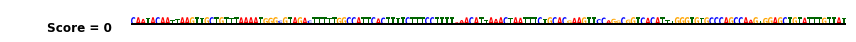

Pattern 1 (PWM & One-hot Sample)


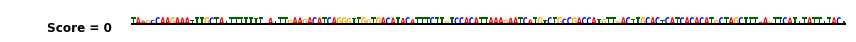

Pattern 2 (PWM & One-hot Sample)


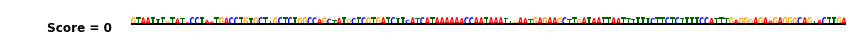

Pattern 3 (PWM & One-hot Sample)


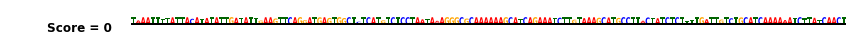

Pattern 4 (PWM & One-hot Sample)


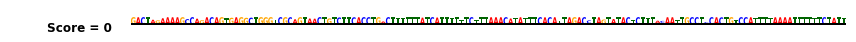

Epoch 2/25
Data index (train) = [  400 17543  5312 ...  5574  9423 40787]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 124s 25ms/step
- Generator Train Loss = -0.040573157
- Entropy Train Loss = 0.002582053
- Discriminator Train Loss (real) = -1.098418
- Discriminator Train Loss (fake) = 0.24022847
- Discriminator Train Loss (grad) = 0.099303
Testing for epoch 2:
- Generator Valid Loss = -5.7924495
- Entropy Valid Loss = 0.0011415534
- Discriminator Valid Loss (real) = -6.250563
- Discriminator Valid Loss (fake) = 5.782922
- Discriminator Valid Loss (grad) = 0.09945161
- Discriminator Valid Score (real) = 6.169773
- Discriminator Valid Score (fake) = 5.8472695
- Discriminator Correct % = 71.14
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


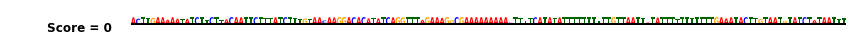

Pattern 1 (PWM & One-hot Sample)


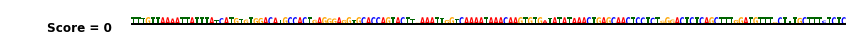

Pattern 2 (PWM & One-hot Sample)


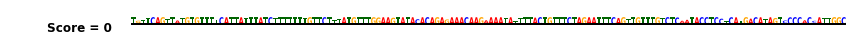

Pattern 3 (PWM & One-hot Sample)


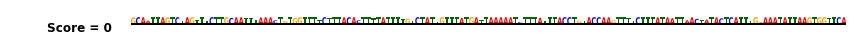

Pattern 4 (PWM & One-hot Sample)


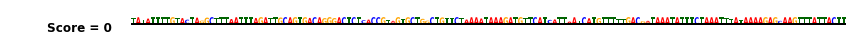

Epoch 3/25
Data index (train) = [21423  7184 34431 ... 34704 36568 36482]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 134s 27ms/step
- Generator Train Loss = -1.5633259
- Entropy Train Loss = 0.0005973053
- Discriminator Train Loss (real) = -2.3268964
- Discriminator Train Loss (fake) = 1.7599406
- Discriminator Train Loss (grad) = 0.09309848
Testing for epoch 3:
- Generator Valid Loss = -0.05003188
- Entropy Valid Loss = 0.000116110234
- Discriminator Valid Loss (real) = -0.33057523
- Discriminator Valid Loss (fake) = 0.007912928
- Discriminator Valid Loss (grad) = 0.10562876
- Discriminator Valid Score (real) = 0.65369487
- Discriminator Valid Score (fake) = 0.029434998
- Discriminator Correct % = 82.79
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


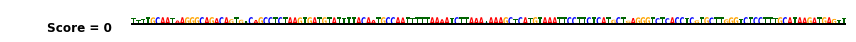

Pattern 1 (PWM & One-hot Sample)


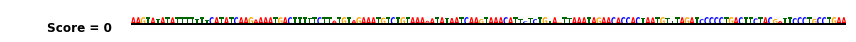

Pattern 2 (PWM & One-hot Sample)


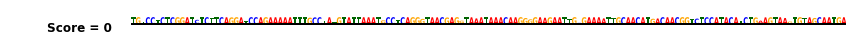

Pattern 3 (PWM & One-hot Sample)


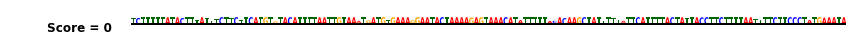

Pattern 4 (PWM & One-hot Sample)


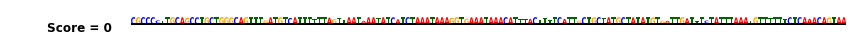

Epoch 4/25
Data index (train) = [22334 43640 36264 ... 36585 39251 43332]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 135s 27ms/step
- Generator Train Loss = -4.2568445
- Entropy Train Loss = 0.0002521733
- Discriminator Train Loss (real) = -4.837964
- Discriminator Train Loss (fake) = 4.3929315
- Discriminator Train Loss (grad) = 0.08760503
Testing for epoch 4:
- Generator Valid Loss = -8.995641
- Entropy Valid Loss = 0.0002215197
- Discriminator Valid Loss (real) = -9.27609
- Discriminator Valid Loss (fake) = 8.973154
- Discriminator Valid Loss (grad) = 0.10314597
- Discriminator Valid Score (real) = 9.390426
- Discriminator Valid Score (fake) = 8.996891
- Discriminator Correct % = 69.4
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


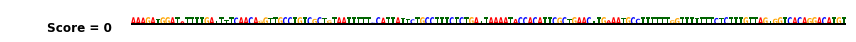

Pattern 1 (PWM & One-hot Sample)


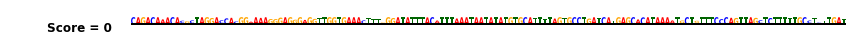

Pattern 2 (PWM & One-hot Sample)


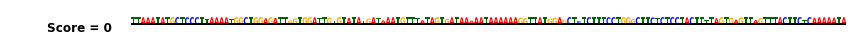

Pattern 3 (PWM & One-hot Sample)


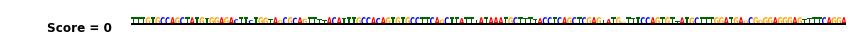

Pattern 4 (PWM & One-hot Sample)


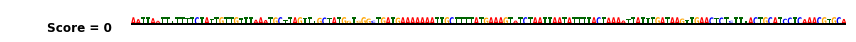

Epoch 5/25
Data index (train) = [28708  2678 21107 ... 27176 10006  6069]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 134s 27ms/step
- Generator Train Loss = -5.029564
- Entropy Train Loss = 0.000117869466
- Discriminator Train Loss (real) = -5.647611
- Discriminator Train Loss (fake) = 5.1638684
- Discriminator Train Loss (grad) = 0.09296256
Testing for epoch 5:
- Generator Valid Loss = -6.9551616
- Entropy Valid Loss = 0.0001888788
- Discriminator Valid Loss (real) = -7.3302436
- Discriminator Valid Loss (fake) = 7.19856
- Discriminator Valid Loss (grad) = 0.08299924
- Discriminator Valid Score (real) = 7.3630123
- Discriminator Valid Score (fake) = 7.08428
- Discriminator Correct % = 66.11
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


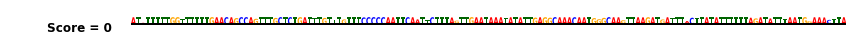

Pattern 1 (PWM & One-hot Sample)


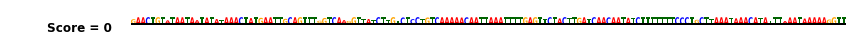

Pattern 2 (PWM & One-hot Sample)


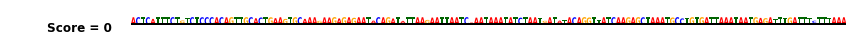

Pattern 3 (PWM & One-hot Sample)


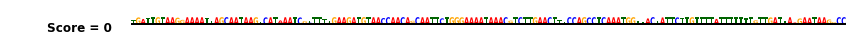

Pattern 4 (PWM & One-hot Sample)


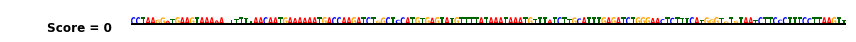

Epoch 6/25
Data index (train) = [ 8370 42828 37376 ... 19578  4101 37646]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 133s 27ms/step
- Generator Train Loss = -7.3498917
- Entropy Train Loss = 9.85654e-05
- Discriminator Train Loss (real) = -7.878331
- Discriminator Train Loss (fake) = 7.4377975
- Discriminator Train Loss (grad) = 0.09120341
Testing for epoch 6:
- Generator Valid Loss = -12.3875065
- Entropy Valid Loss = 7.037992e-05
- Discriminator Valid Loss (real) = -12.112159
- Discriminator Valid Loss (fake) = 12.082635
- Discriminator Valid Loss (grad) = 0.13491215
- Discriminator Valid Score (real) = 12.175489
- Discriminator Valid Score (fake) = 12.002261
- Discriminator Correct % = 60.15
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


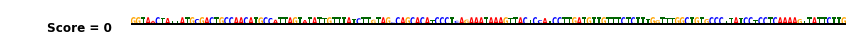

Pattern 1 (PWM & One-hot Sample)


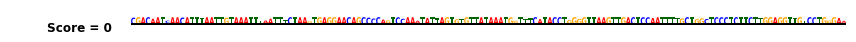

Pattern 2 (PWM & One-hot Sample)


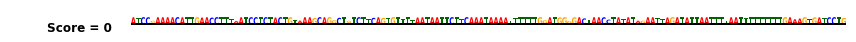

Pattern 3 (PWM & One-hot Sample)


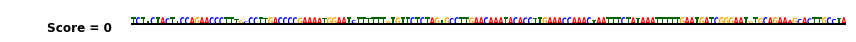

Pattern 4 (PWM & One-hot Sample)


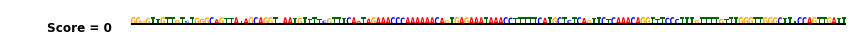

Epoch 7/25
Data index (train) = [ 7677  4694 16544 ... 36997 16162 11011]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 133s 27ms/step
- Generator Train Loss = -14.091135
- Entropy Train Loss = 6.425449e-05
- Discriminator Train Loss (real) = -14.584353
- Discriminator Train Loss (fake) = 14.20476
- Discriminator Train Loss (grad) = 0.08970642
Testing for epoch 7:
- Generator Valid Loss = -25.339102
- Entropy Valid Loss = 1.9425695e-06
- Discriminator Valid Loss (real) = -25.041151
- Discriminator Valid Loss (fake) = 24.98993
- Discriminator Valid Loss (grad) = 0.08718863
- Discriminator Valid Score (real) = 25.518559
- Discriminator Valid Score (fake) = 25.140284
- Discriminator Correct % = 71.79
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


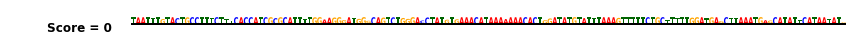

Pattern 1 (PWM & One-hot Sample)


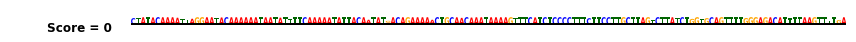

Pattern 2 (PWM & One-hot Sample)


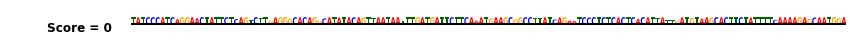

Pattern 3 (PWM & One-hot Sample)


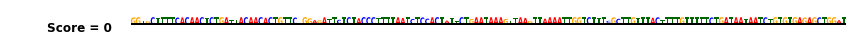

Pattern 4 (PWM & One-hot Sample)


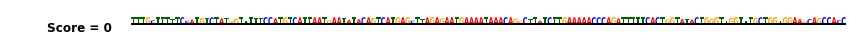

Epoch 8/25
Data index (train) = [ 5843  8591 22464 ... 10193 35970 26558]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 135s 27ms/step
- Generator Train Loss = -18.40032
- Entropy Train Loss = 2.03923e-05
- Discriminator Train Loss (real) = -18.798986
- Discriminator Train Loss (fake) = 18.487392
- Discriminator Train Loss (grad) = 0.08225956
Testing for epoch 8:
- Generator Valid Loss = -19.827974
- Entropy Valid Loss = 1.1286178e-06
- Discriminator Valid Loss (real) = -19.822472
- Discriminator Valid Loss (fake) = 19.842018
- Discriminator Valid Loss (grad) = 0.07141907
- Discriminator Valid Score (real) = 19.93787
- Discriminator Valid Score (fake) = 19.830116
- Discriminator Correct % = 50.81
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


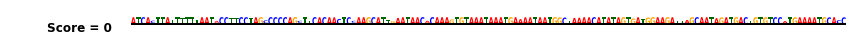

Pattern 1 (PWM & One-hot Sample)


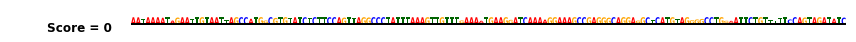

Pattern 2 (PWM & One-hot Sample)


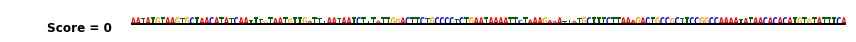

Pattern 3 (PWM & One-hot Sample)


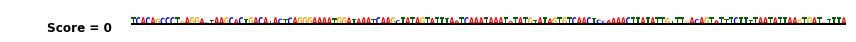

Pattern 4 (PWM & One-hot Sample)


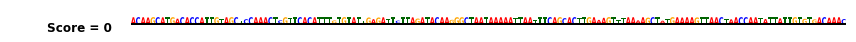

Epoch 9/25
Data index (train) = [39906 23092  8709 ... 41431 35162 22498]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 135s 27ms/step
- Generator Train Loss = -18.519255
- Entropy Train Loss = 1.224342e-05
- Discriminator Train Loss (real) = -18.947071
- Discriminator Train Loss (fake) = 18.619982
- Discriminator Train Loss (grad) = 0.077289425
Testing for epoch 9:
- Generator Valid Loss = -15.912103
- Entropy Valid Loss = 0.0
- Discriminator Valid Loss (real) = -16.126276
- Discriminator Valid Loss (fake) = 15.896218
- Discriminator Valid Loss (grad) = 0.06706403
- Discriminator Valid Score (real) = 16.135775
- Discriminator Valid Score (fake) = 15.868458
- Discriminator Correct % = 66.07
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


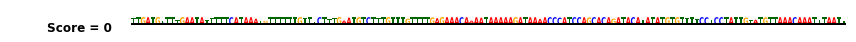

Pattern 1 (PWM & One-hot Sample)


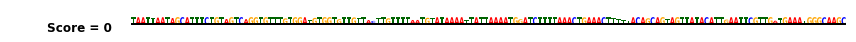

Pattern 2 (PWM & One-hot Sample)


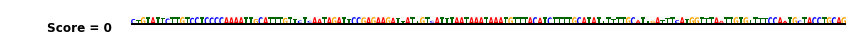

Pattern 3 (PWM & One-hot Sample)


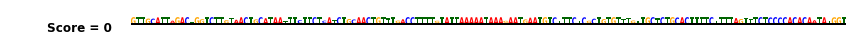

Pattern 4 (PWM & One-hot Sample)


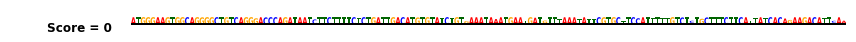

Epoch 10/25
Data index (train) = [ 6756 16819 17919 ... 17341 32310 26251]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 133s 27ms/step
- Generator Train Loss = -26.21027
- Entropy Train Loss = 1.4869094e-05
- Discriminator Train Loss (real) = -26.625431
- Discriminator Train Loss (fake) = 26.243774
- Discriminator Train Loss (grad) = 0.07805879
Testing for epoch 10:
- Generator Valid Loss = -19.607382
- Entropy Valid Loss = 9.600605e-06
- Discriminator Valid Loss (real) = -19.706284
- Discriminator Valid Loss (fake) = 19.61276
- Discriminator Valid Loss (grad) = 0.08238148
- Discriminator Valid Score (real) = 19.881868
- Discriminator Valid Score (fake) = 19.61317
- Discriminator Correct % = 63.27
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


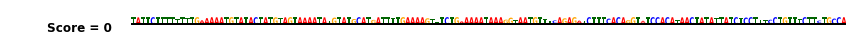

Pattern 1 (PWM & One-hot Sample)


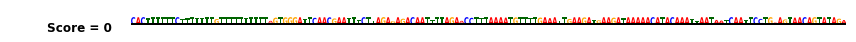

Pattern 2 (PWM & One-hot Sample)


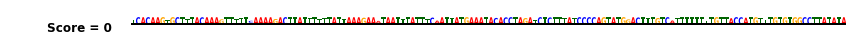

Pattern 3 (PWM & One-hot Sample)


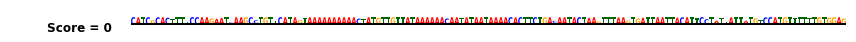

Pattern 4 (PWM & One-hot Sample)


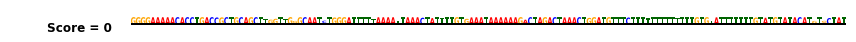

Epoch 11/25
Data index (train) = [41547  4355 10154 ... 25413 32390 22330]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 134s 27ms/step
- Generator Train Loss = -29.072765
- Entropy Train Loss = 1.2318343e-06
- Discriminator Train Loss (real) = -29.520918
- Discriminator Train Loss (fake) = 29.178728
- Discriminator Train Loss (grad) = 0.078296594
Testing for epoch 11:
- Generator Valid Loss = -24.689014
- Entropy Valid Loss = 0.0
- Discriminator Valid Loss (real) = -25.117697
- Discriminator Valid Loss (fake) = 24.445494
- Discriminator Valid Loss (grad) = 0.07366418
- Discriminator Valid Score (real) = 24.92303
- Discriminator Valid Score (fake) = 24.581903
- Discriminator Correct % = 73.38
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


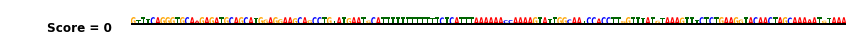

Pattern 1 (PWM & One-hot Sample)


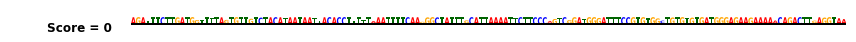

Pattern 2 (PWM & One-hot Sample)


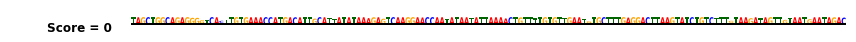

Pattern 3 (PWM & One-hot Sample)


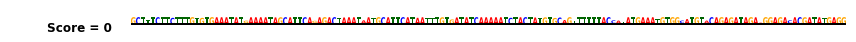

Pattern 4 (PWM & One-hot Sample)


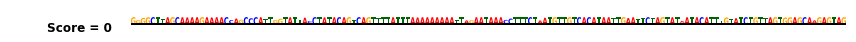

Epoch 12/25
Data index (train) = [30469 14533 27551 ... 16490 17300  1013]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 133s 27ms/step
- Generator Train Loss = -33.067257
- Entropy Train Loss = 1.9585789e-06
- Discriminator Train Loss (real) = -33.447117
- Discriminator Train Loss (fake) = 33.111637
- Discriminator Train Loss (grad) = 0.076527454
Testing for epoch 12:
- Generator Valid Loss = -51.067932
- Entropy Valid Loss = 0.0
- Discriminator Valid Loss (real) = -51.390427
- Discriminator Valid Loss (fake) = 51.07932
- Discriminator Valid Loss (grad) = 0.07619935
- Discriminator Valid Score (real) = 51.386784
- Discriminator Valid Score (fake) = 51.143642
- Discriminator Correct % = 67.78
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


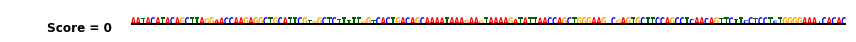

Pattern 1 (PWM & One-hot Sample)


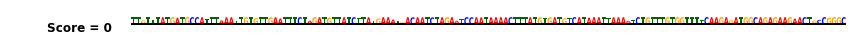

Pattern 2 (PWM & One-hot Sample)


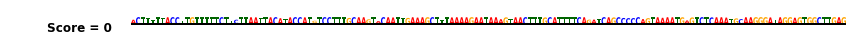

Pattern 3 (PWM & One-hot Sample)


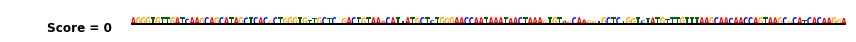

Pattern 4 (PWM & One-hot Sample)


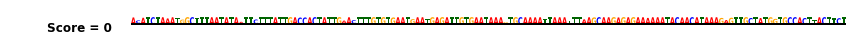

Epoch 13/25
Data index (train) = [38924   270 13070 ...  6744  8469 13333]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 134s 27ms/step
- Generator Train Loss = -34.48272
- Entropy Train Loss = 1.4622062e-06
- Discriminator Train Loss (real) = -34.8371
- Discriminator Train Loss (fake) = 34.56103
- Discriminator Train Loss (grad) = 0.07458916
Testing for epoch 13:
- Generator Valid Loss = -50.36776
- Entropy Valid Loss = 0.0
- Discriminator Valid Loss (real) = -50.583664
- Discriminator Valid Loss (fake) = 50.328003
- Discriminator Valid Loss (grad) = 0.06740064
- Discriminator Valid Score (real) = 50.578606
- Discriminator Valid Score (fake) = 50.320755
- Discriminator Correct % = 67.82
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


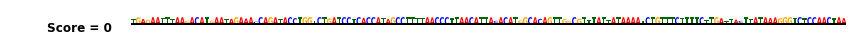

Pattern 1 (PWM & One-hot Sample)


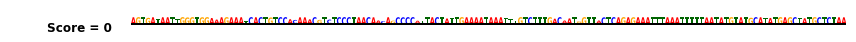

Pattern 2 (PWM & One-hot Sample)


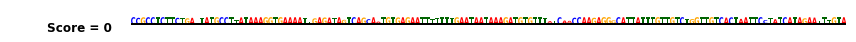

Pattern 3 (PWM & One-hot Sample)


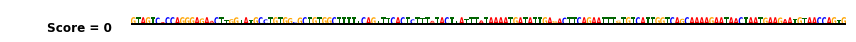

Pattern 4 (PWM & One-hot Sample)


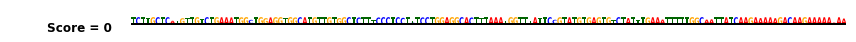

Epoch 14/25
Data index (train) = [12544  9087 35339 ... 28564 16762 35246]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 137s 27ms/step
- Generator Train Loss = -45.134777
- Entropy Train Loss = 1.0107607e-06
- Discriminator Train Loss (real) = -45.468575
- Discriminator Train Loss (fake) = 45.1312
- Discriminator Train Loss (grad) = 0.074325815
Testing for epoch 14:
- Generator Valid Loss = -56.44376
- Entropy Valid Loss = 0.0
- Discriminator Valid Loss (real) = -56.485657
- Discriminator Valid Loss (fake) = 55.992367
- Discriminator Valid Loss (grad) = 0.09814134
- Discriminator Valid Score (real) = 56.35771
- Discriminator Valid Score (fake) = 56.244457
- Discriminator Correct % = 52.8
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


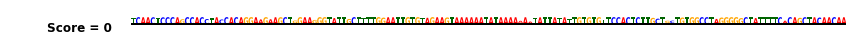

Pattern 1 (PWM & One-hot Sample)


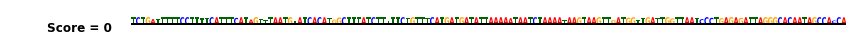

Pattern 2 (PWM & One-hot Sample)


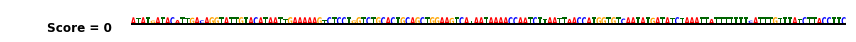

Pattern 3 (PWM & One-hot Sample)


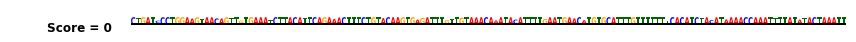

Pattern 4 (PWM & One-hot Sample)


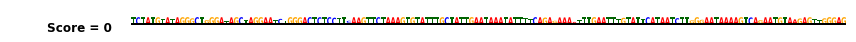

Epoch 15/25
Data index (train) = [ 4014 41911  6485 ... 36581 14409 25400]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 135s 27ms/step
- Generator Train Loss = -56.827187
- Entropy Train Loss = 1.6136468e-06
- Discriminator Train Loss (real) = -57.207764
- Discriminator Train Loss (fake) = 56.8659
- Discriminator Train Loss (grad) = 0.0790389
Testing for epoch 15:
- Generator Valid Loss = -67.266655
- Entropy Valid Loss = 0.0
- Discriminator Valid Loss (real) = -67.68494
- Discriminator Valid Loss (fake) = 67.41994
- Discriminator Valid Loss (grad) = 0.101700544
- Discriminator Valid Score (real) = 67.54096
- Discriminator Valid Score (fake) = 67.24741
- Discriminator Correct % = 67.74
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


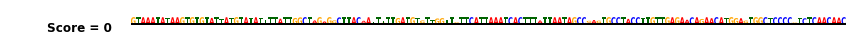

Pattern 1 (PWM & One-hot Sample)


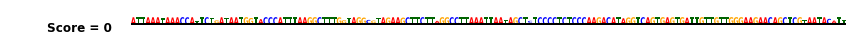

Pattern 2 (PWM & One-hot Sample)


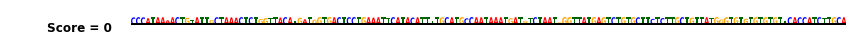

Pattern 3 (PWM & One-hot Sample)


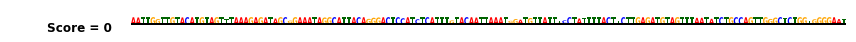

Pattern 4 (PWM & One-hot Sample)


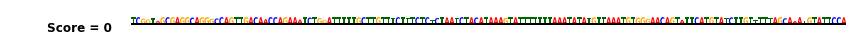

Epoch 16/25
Data index (train) = [14416 36067 36357 ...  7935 30416  1495]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 135s 27ms/step
- Generator Train Loss = -60.322792
- Entropy Train Loss = 6.930232e-07
- Discriminator Train Loss (real) = -60.657932
- Discriminator Train Loss (fake) = 60.415287
- Discriminator Train Loss (grad) = 0.077691846
Testing for epoch 16:
- Generator Valid Loss = -45.091568
- Entropy Valid Loss = 0.0
- Discriminator Valid Loss (real) = -45.282814
- Discriminator Valid Loss (fake) = 45.06784
- Discriminator Valid Loss (grad) = 0.070523426
- Discriminator Valid Score (real) = 45.30847
- Discriminator Valid Score (fake) = 45.00803
- Discriminator Correct % = 69.76
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


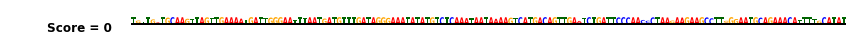

Pattern 1 (PWM & One-hot Sample)


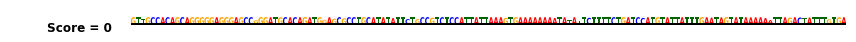

Pattern 2 (PWM & One-hot Sample)


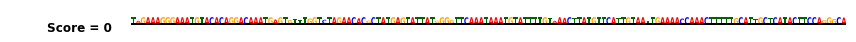

Pattern 3 (PWM & One-hot Sample)


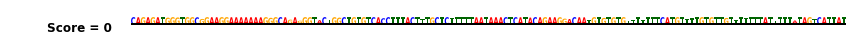

Pattern 4 (PWM & One-hot Sample)


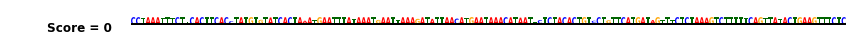

Epoch 17/25
Data index (train) = [40654 37478 30392 ... 21705  5049 38048]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 138s 28ms/step
- Generator Train Loss = -51.436447
- Entropy Train Loss = 1.0309965e-06
- Discriminator Train Loss (real) = -51.739643
- Discriminator Train Loss (fake) = 51.512627
- Discriminator Train Loss (grad) = 0.07547808
Testing for epoch 17:
- Generator Valid Loss = -34.959763
- Entropy Valid Loss = 0.0
- Discriminator Valid Loss (real) = -34.87866
- Discriminator Valid Loss (fake) = 34.915863
- Discriminator Valid Loss (grad) = 0.0728567
- Discriminator Valid Score (real) = 34.97732
- Discriminator Valid Score (fake) = 34.914272
- Discriminator Correct % = 51.3
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


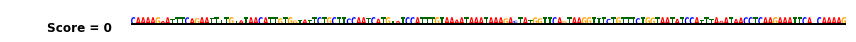

Pattern 1 (PWM & One-hot Sample)


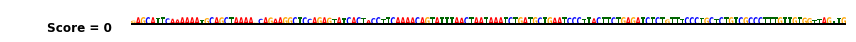

Pattern 2 (PWM & One-hot Sample)


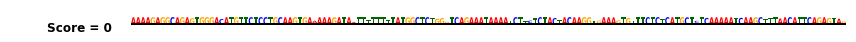

Pattern 3 (PWM & One-hot Sample)


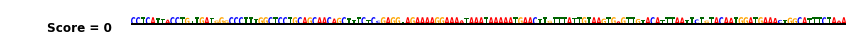

Pattern 4 (PWM & One-hot Sample)


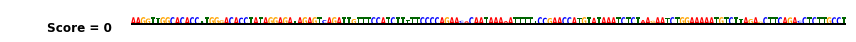

Epoch 18/25
Data index (train) = [30298 38520  1698 ... 40066  5856  6031]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 137s 27ms/step
- Generator Train Loss = -46.585148
- Entropy Train Loss = 4.323721e-07
- Discriminator Train Loss (real) = -46.863514
- Discriminator Train Loss (fake) = 46.601017
- Discriminator Train Loss (grad) = 0.07298483
Testing for epoch 18:
- Generator Valid Loss = -49.46827
- Entropy Valid Loss = 0.0
- Discriminator Valid Loss (real) = -49.483734
- Discriminator Valid Loss (fake) = 49.460526
- Discriminator Valid Loss (grad) = 0.07807804
- Discriminator Valid Score (real) = 49.808
- Discriminator Valid Score (fake) = 49.487858
- Discriminator Correct % = 69.76
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


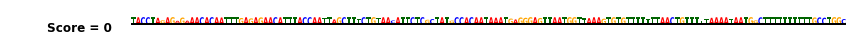

Pattern 1 (PWM & One-hot Sample)


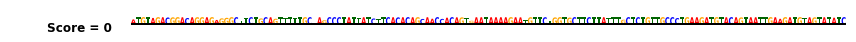

Pattern 2 (PWM & One-hot Sample)


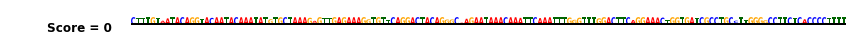

Pattern 3 (PWM & One-hot Sample)


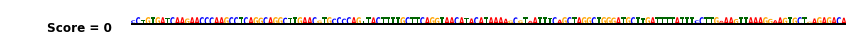

Pattern 4 (PWM & One-hot Sample)


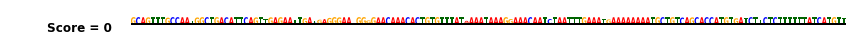

Epoch 19/25
Data index (train) = [19940 32371 37122 ...  9553 43157 20027]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 135s 27ms/step
- Generator Train Loss = -58.26321
- Entropy Train Loss = 0.0
- Discriminator Train Loss (real) = -58.542927
- Discriminator Train Loss (fake) = 58.278725
- Discriminator Train Loss (grad) = 0.07590298
Testing for epoch 19:
- Generator Valid Loss = -61.53125
- Entropy Valid Loss = 0.0
- Discriminator Valid Loss (real) = -61.567997
- Discriminator Valid Loss (fake) = 61.696167
- Discriminator Valid Loss (grad) = 0.07600933
- Discriminator Valid Score (real) = 61.824917
- Discriminator Valid Score (fake) = 61.537514
- Discriminator Correct % = 68.02
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


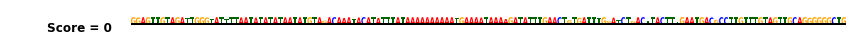

Pattern 1 (PWM & One-hot Sample)


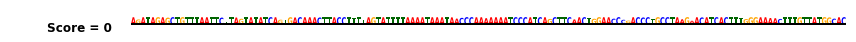

Pattern 2 (PWM & One-hot Sample)


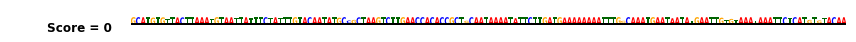

Pattern 3 (PWM & One-hot Sample)


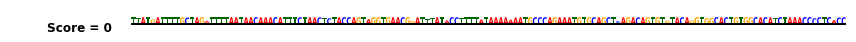

Pattern 4 (PWM & One-hot Sample)


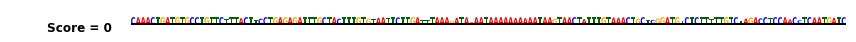

Epoch 20/25
Data index (train) = [19260 44124 10396 ... 24493 10941  1091]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 133s 27ms/step
- Generator Train Loss = -46.602886
- Entropy Train Loss = 1.3798475e-08
- Discriminator Train Loss (real) = -46.872353
- Discriminator Train Loss (fake) = 46.65733
- Discriminator Train Loss (grad) = 0.074624
Testing for epoch 20:
- Generator Valid Loss = -41.649708
- Entropy Valid Loss = 0.0
- Discriminator Valid Loss (real) = -41.900757
- Discriminator Valid Loss (fake) = 41.709064
- Discriminator Valid Loss (grad) = 0.06458232
- Discriminator Valid Score (real) = 41.948742
- Discriminator Valid Score (fake) = 41.746273
- Discriminator Correct % = 62.5
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


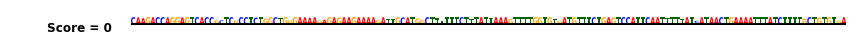

Pattern 1 (PWM & One-hot Sample)


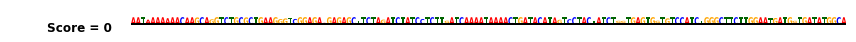

Pattern 2 (PWM & One-hot Sample)


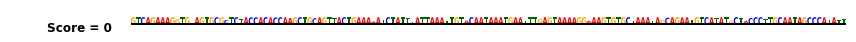

Pattern 3 (PWM & One-hot Sample)


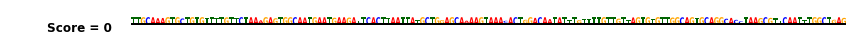

Pattern 4 (PWM & One-hot Sample)


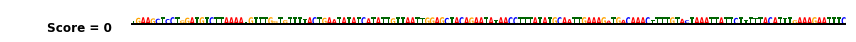

Epoch 21/25
Data index (train) = [40024 11293 17627 ... 21457 36050 24269]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 133s 27ms/step
- Generator Train Loss = -61.465584
- Entropy Train Loss = 0.0
- Discriminator Train Loss (real) = -61.80689
- Discriminator Train Loss (fake) = 61.47905
- Discriminator Train Loss (grad) = 0.07749595
Testing for epoch 21:
- Generator Valid Loss = -62.63687
- Entropy Valid Loss = 0.0
- Discriminator Valid Loss (real) = -62.9085
- Discriminator Valid Loss (fake) = 62.800564
- Discriminator Valid Loss (grad) = 0.07438962
- Discriminator Valid Score (real) = 62.6886
- Discriminator Valid Score (fake) = 62.582912
- Discriminator Correct % = 52.6
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


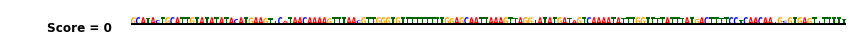

Pattern 1 (PWM & One-hot Sample)


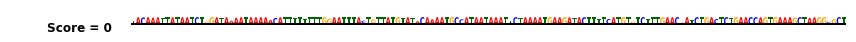

Pattern 2 (PWM & One-hot Sample)


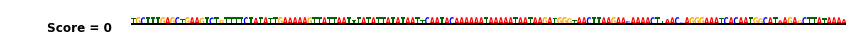

Pattern 3 (PWM & One-hot Sample)


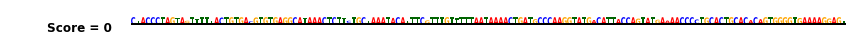

Pattern 4 (PWM & One-hot Sample)


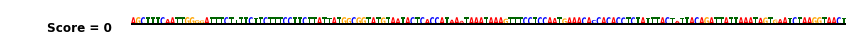

Epoch 22/25
Data index (train) = [13187 21124 29943 ... 41766   662 13285]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 132s 26ms/step
- Generator Train Loss = -52.581547
- Entropy Train Loss = 0.0
- Discriminator Train Loss (real) = -52.827362
- Discriminator Train Loss (fake) = 52.628475
- Discriminator Train Loss (grad) = 0.073792495
Testing for epoch 22:
- Generator Valid Loss = -58.447735
- Entropy Valid Loss = 0.0
- Discriminator Valid Loss (real) = -57.990677
- Discriminator Valid Loss (fake) = 58.461243
- Discriminator Valid Loss (grad) = 0.06647966
- Discriminator Valid Score (real) = 58.49579
- Discriminator Valid Score (fake) = 58.27184
- Discriminator Correct % = 64.41
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


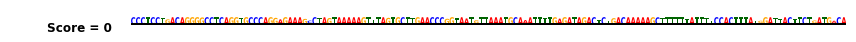

Pattern 1 (PWM & One-hot Sample)


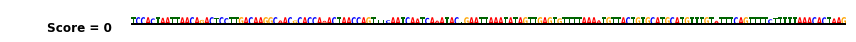

Pattern 2 (PWM & One-hot Sample)


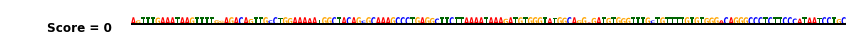

Pattern 3 (PWM & One-hot Sample)


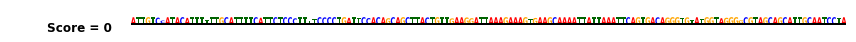

Pattern 4 (PWM & One-hot Sample)


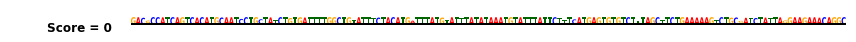

Epoch 23/25
Data index (train) = [ 2509  7352 39304 ...  8740 35453  4822]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 131s 26ms/step
- Generator Train Loss = -34.573402
- Entropy Train Loss = 0.0
- Discriminator Train Loss (real) = -34.859585
- Discriminator Train Loss (fake) = 34.635414
- Discriminator Train Loss (grad) = 0.071942985
Testing for epoch 23:
- Generator Valid Loss = -40.867367
- Entropy Valid Loss = 0.0
- Discriminator Valid Loss (real) = -40.99137
- Discriminator Valid Loss (fake) = 40.98259
- Discriminator Valid Loss (grad) = 0.06901124
- Discriminator Valid Score (real) = 41.09871
- Discriminator Valid Score (fake) = 40.90521
- Discriminator Correct % = 58.44
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


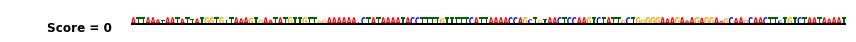

Pattern 1 (PWM & One-hot Sample)


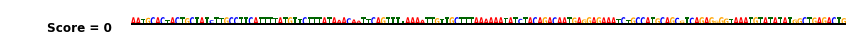

Pattern 2 (PWM & One-hot Sample)


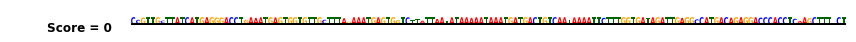

Pattern 3 (PWM & One-hot Sample)


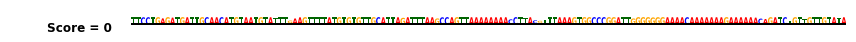

Pattern 4 (PWM & One-hot Sample)


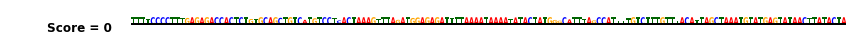

Epoch 24/25
Data index (train) = [14037 43076 23226 ... 34499 27747 13104]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 132s 26ms/step
- Generator Train Loss = -41.29717
- Entropy Train Loss = 0.0
- Discriminator Train Loss (real) = -41.643433
- Discriminator Train Loss (fake) = 41.31764
- Discriminator Train Loss (grad) = 0.093659274
Testing for epoch 24:
- Generator Valid Loss = -49.218964
- Entropy Valid Loss = 0.0
- Discriminator Valid Loss (real) = -49.759815
- Discriminator Valid Loss (fake) = 49.419155
- Discriminator Valid Loss (grad) = 0.18196684
- Discriminator Valid Score (real) = 49.90072
- Discriminator Valid Score (fake) = 49.385426
- Discriminator Correct % = 76.7
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


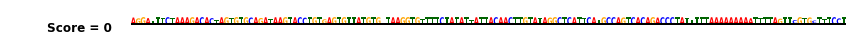

Pattern 1 (PWM & One-hot Sample)


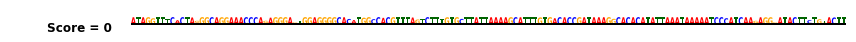

Pattern 2 (PWM & One-hot Sample)


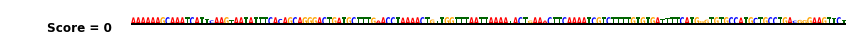

Pattern 3 (PWM & One-hot Sample)


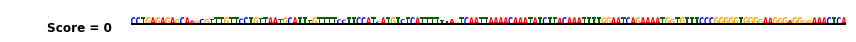

Pattern 4 (PWM & One-hot Sample)


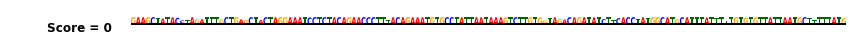

Epoch 25/25
Data index (train) = [10044   769 21089 ... 24354  5663  8698]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 131s 26ms/step
- Generator Train Loss = -50.00675
- Entropy Train Loss = 0.0
- Discriminator Train Loss (real) = -50.689682
- Discriminator Train Loss (fake) = 50.041092
- Discriminator Train Loss (grad) = 0.1870115
Testing for epoch 25:
- Generator Valid Loss = -39.6135
- Entropy Valid Loss = 0.0
- Discriminator Valid Loss (real) = -40.435165
- Discriminator Valid Loss (fake) = 39.653484
- Discriminator Valid Loss (grad) = 0.16083251
- Discriminator Valid Score (real) = 40.36718
- Discriminator Valid Score (fake) = 39.61097
- Discriminator Correct % = 85.06
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


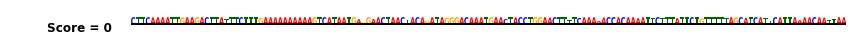

Pattern 1 (PWM & One-hot Sample)


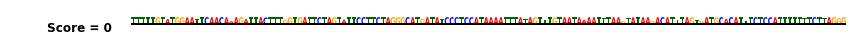

Pattern 2 (PWM & One-hot Sample)


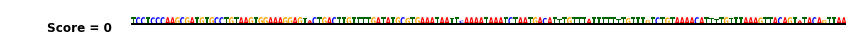

Pattern 3 (PWM & One-hot Sample)


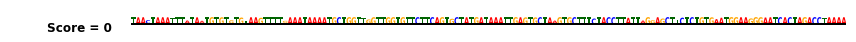

Pattern 4 (PWM & One-hot Sample)


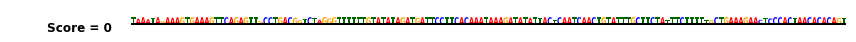

In [111]:

from_epoch = 1

n_epochs = 25

n_iters = 5000

validation_frequency = 1000

training_ratio = 5

verbose = True
verbose_n_pwms, verbose_n_samples = 5, 0

#Specify entropy anneal function
entropy_anneal_func = lambda epoch: 1.0

max_n_valid_batches = 200

epoch_train_history = defaultdict(list)
epoch_valid_history = defaultdict(list)
valid_history = defaultdict(list)

for epoch in range(from_epoch, n_epochs + 1) :
    print('Epoch {}/{}'.format(epoch, n_epochs))
    print("Data index (train) = " + str(data_gens['train'].indexes))

    progress_bar = Progbar(target=n_iters)

    K.set_value(entropy_anneal_coeff, entropy_anneal_func(epoch - 1))
    
    print("Entropy anneal coeff. = " + str(round(K.get_value(entropy_anneal_coeff), 3)))
    
    gen_train_losses = []
    ent_train_losses = []
    
    disc_real_train_losses = []
    disc_fake_train_losses = []
    disc_gp_train_losses = []
    
    for index in range(1, n_iters + 1) :
        sequence_batch = data_gens['train'][(index - 1) % len(data_gens['train'])][0][0]
        
        class_batch = np.zeros((batch_size, 1), dtype=np.int)
        seed_batch = np.random.uniform(low=-1.0, high=1.0, size=(batch_size, 100))
        
        _, real_l, fake_l, gp_l = discriminator_model_real_data.train_on_batch(
            [class_batch, seed_batch, sequence_batch],
            [dummy_data_target, dummy_data_target, dummy_data_target]
        )
        
        disc_real_train_losses.append(real_l)
        disc_fake_train_losses.append(fake_l)
        disc_gp_train_losses.append(gp_l)
        
        if index % training_ratio == 0 :
            
            class_batch = np.zeros((batch_size, 1), dtype=np.int)
            seed_batch = np.random.uniform(low=-1.0, high=1.0, size=(batch_size, 100))
            
            _, gen_l, ent_l = discriminator_model_fake_data.train_on_batch(
                [class_batch, seed_batch],
                [dummy_data_target, dummy_data_target]
            )
            
            gen_train_losses.append(gen_l)
            ent_train_losses.append(ent_l)
        
        if index % validation_frequency == 0 :
            evaluate_gan(data_gens['valid'], generator_model, discriminator_model, valid_history, batch_size=batch_size, max_n_valid_batches=max_n_valid_batches)
        
        progress_bar.update(index)
    
    gen_train_loss = np.mean(np.array(gen_train_losses), axis=0)
    ent_train_loss = np.mean(np.array(ent_train_losses), axis=0)
    
    disc_real_train_loss = np.mean(np.array(disc_real_train_losses), axis=0)
    disc_fake_train_loss = np.mean(np.array(disc_fake_train_losses), axis=0)
    disc_gp_train_loss = np.mean(np.array(disc_gp_train_losses), axis=0)
    
    epoch_train_history['generator_loss'].append(gen_train_loss)
    epoch_train_history['entropy_loss'].append(ent_train_loss)
    epoch_train_history['discriminator_real_loss'].append(disc_real_train_loss)
    epoch_train_history['discriminator_fake_loss'].append(disc_fake_train_loss)
    epoch_train_history['discriminator_gp_loss'].append(disc_gp_train_loss)
    
    print("- Generator Train Loss = " + str(gen_train_loss))
    print("- Entropy Train Loss = " + str(ent_train_loss))
    print("- Discriminator Train Loss (real) = " + str(disc_real_train_loss))
    print("- Discriminator Train Loss (fake) = " + str(disc_fake_train_loss))
    print("- Discriminator Train Loss (grad) = " + str(disc_gp_train_loss))
    
    
    print('Testing for epoch {}:'.format(epoch))
    
    evaluate_gan_loss(data_gens['valid'], discriminator_model_fake_data, discriminator_model_real_data, epoch_valid_history, batch_size=batch_size, max_n_valid_batches=max_n_valid_batches)
    
    print("- Generator Valid Loss = " + str(epoch_valid_history['generator_loss'][-1]))
    print("- Entropy Valid Loss = " + str(epoch_valid_history['entropy_loss'][-1]))
    print("- Discriminator Valid Loss (real) = " + str(epoch_valid_history['discriminator_real_loss'][-1]))
    print("- Discriminator Valid Loss (fake) = " + str(epoch_valid_history['discriminator_fake_loss'][-1]))
    print("- Discriminator Valid Loss (grad) = " + str(epoch_valid_history['discriminator_gp_loss'][-1]))
    
    evaluate_gan(data_gens['valid'], generator_model, discriminator_model, epoch_valid_history, batch_size=batch_size, max_n_valid_batches=max_n_valid_batches)
    
    print("- Discriminator Valid Score (real) = " + str(epoch_valid_history['discriminator_real_score'][-1]))
    print("- Discriminator Valid Score (fake) = " + str(epoch_valid_history['discriminator_fake_score'][-1]))
    print("- Discriminator Correct % = " + str(round(epoch_valid_history['discriminator_accuracy'][-1] * 100, 2)))

    if verbose :
    
        print("- Fake Patterns (Randomly Generated) -")
        
        class_batch = np.zeros((batch_size, 1), dtype=np.int)
        seed_batch = np.random.uniform(low=-1.0, high=1.0, size=(batch_size, 100))
        
        _, fake_pwm_batch, fake_sequence_batch = generator_model.predict_on_batch(x=[class_batch, seed_batch])

        for plot_i in range(min(verbose_n_pwms, batch_size)) :
            print('Pattern ' + str(plot_i) + ' (PWM & One-hot Sample)')
            plot_gan_logo(fake_pwm_batch[plot_i, 0, :, :], 0, sequence_template=sequence_templates[0], figsize=(12, 0.5), width_ratios=[1, 7], logo_height=1.0, plot_start=125 - 70, plot_end=125 + 6 + 70)
            
    data_gens['train'].on_epoch_end()


--- Training Losses ---

(Generator Losses)


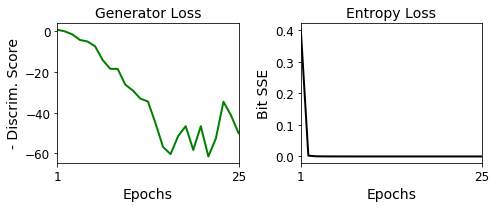

(Discriminator Losses)


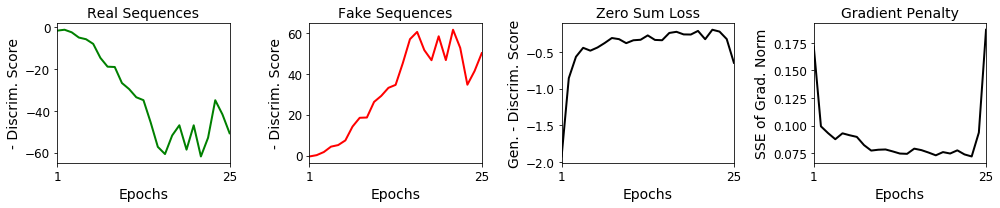

--- Validation Losses ---

(Generator Losses)


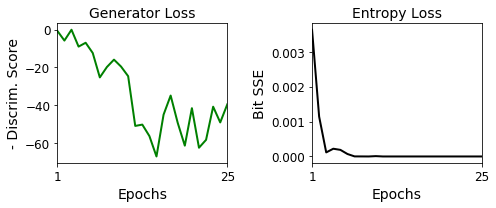

(Discriminator Losses)


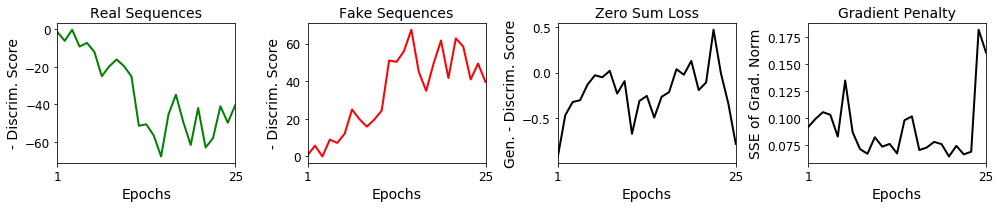

In [112]:

for eval_str, eval_history in [('Training', epoch_train_history), ('Validation', epoch_valid_history)] :

    print("--- " + eval_str + " Losses ---")
    print("")
    
    print("(Generator Losses)")
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(3.5 * 2, 3))

    ax1.plot(np.arange(1, n_epochs + 1), eval_history['generator_loss'], linewidth=2, color='green')

    plt.sca(ax1)
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel("- Discrim. Score", fontsize=14)
    plt.title("Generator Loss", fontsize=14)
    plt.xlim(1, n_epochs)
    plt.xticks([1, n_epochs], [1, n_epochs], fontsize=12)
    plt.yticks(fontsize=12)

    ax2.plot(np.arange(1, n_epochs + 1), eval_history['entropy_loss'], linewidth=2, color='black')

    plt.sca(ax2)
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel("Bit SSE", fontsize=14)
    plt.title("Entropy Loss", fontsize=14)
    plt.xlim(1, n_epochs)
    plt.xticks([1, n_epochs], [1, n_epochs], fontsize=12)
    plt.yticks(fontsize=12)

    plt.tight_layout()

    plt.show()
    
    print("(Discriminator Losses)")

    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(3.5 * 4, 3))

    ax1.plot(np.arange(1, n_epochs + 1), eval_history['discriminator_real_loss'], linewidth=2, color='green')

    plt.sca(ax1)
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel("- Discrim. Score", fontsize=14)
    plt.title("Real Sequences", fontsize=14)
    plt.xlim(1, n_epochs)
    plt.xticks([1, n_epochs], [1, n_epochs], fontsize=12)
    plt.yticks(fontsize=12)

    ax2.plot(np.arange(1, n_epochs + 1), eval_history['discriminator_fake_loss'], linewidth=2, color='red')

    plt.sca(ax2)
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel("- Discrim. Score", fontsize=14)
    plt.title("Fake Sequences", fontsize=14)
    plt.xlim(1, n_epochs)
    plt.xticks([1, n_epochs], [1, n_epochs], fontsize=12)
    plt.yticks(fontsize=12)

    ax3.plot(np.arange(1, n_epochs + 1), np.ravel(eval_history['discriminator_fake_loss']) + np.ravel(eval_history['discriminator_real_loss']), linewidth=2, color='black')

    plt.sca(ax3)
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel("Gen. - Discrim. Score", fontsize=14)
    plt.title("Zero Sum Loss", fontsize=14)
    plt.xlim(1, n_epochs)
    plt.xticks([1, n_epochs], [1, n_epochs], fontsize=12)
    plt.yticks(fontsize=12)
    
    ax4.plot(np.arange(1, n_epochs + 1), eval_history['discriminator_gp_loss'], linewidth=2, color='black')

    plt.sca(ax4)
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel("SSE of Grad. Norm", fontsize=14)
    plt.title("Gradient Penalty", fontsize=14)
    plt.xlim(1, n_epochs)
    plt.xticks([1, n_epochs], [1, n_epochs], fontsize=12)
    plt.yticks(fontsize=12)

    plt.tight_layout()

    plt.show()


Validation Metrics (Frequent)


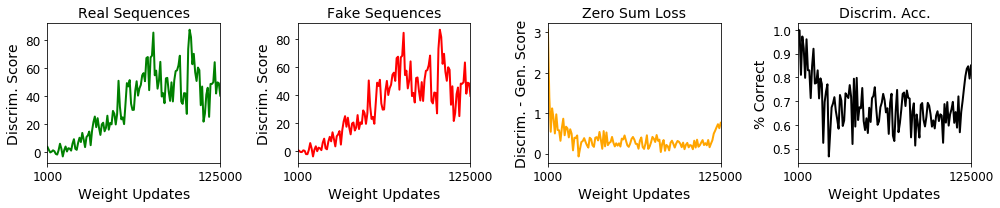

In [113]:
print("Validation Metrics (Frequent)")

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(3.5 * 4, 3))

t = np.arange(1, len(valid_history['discriminator_real_score']) + 1) * validation_frequency

ax1.plot(t, valid_history['discriminator_real_score'], linewidth=2, color='green')

plt.sca(ax1)
plt.xlabel("Weight Updates", fontsize=14)
plt.ylabel("Discrim. Score", fontsize=14)
plt.title("Real Sequences", fontsize=14)
plt.xlim(t[0], t[-1])
plt.xticks([t[0], t[-1]], [t[0], t[-1]], fontsize=12)
plt.yticks(fontsize=12)

ax2.plot(t, valid_history['discriminator_fake_score'], linewidth=2, color='red')

plt.sca(ax2)
plt.xlabel("Weight Updates", fontsize=14)
plt.ylabel("Discrim. Score", fontsize=14)
plt.title("Fake Sequences", fontsize=14)
plt.xlim(t[0], t[-1])
plt.xticks([t[0], t[-1]], [t[0], t[-1]], fontsize=12)
plt.yticks(fontsize=12)

ax3.plot(t, np.ravel(valid_history['discriminator_real_score']) - np.ravel(valid_history['discriminator_fake_score']), linewidth=2, color='orange')

plt.sca(ax3)
plt.xlabel("Weight Updates", fontsize=14)
plt.ylabel("Discrim. - Gen. Score", fontsize=14)
plt.title("Zero Sum Loss", fontsize=14)
plt.xlim(t[0], t[-1])
plt.xticks([t[0], t[-1]], [t[0], t[-1]], fontsize=12)
plt.yticks(fontsize=12)

ax4.plot(t, valid_history['discriminator_accuracy'], linewidth=2, color='black')

plt.sca(ax4)
plt.xlabel("Weight Updates", fontsize=14)
plt.ylabel("% Correct", fontsize=14)
plt.title("Discrim. Acc.", fontsize=14)
plt.xlim(t[0], t[-1])
plt.xticks([t[0], t[-1]], [t[0], t[-1]], fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()

plt.show()

In [114]:
#Save model weights and evaluation metrics
save_dir = 'saved_models'

task_suffix = '_apadb'

gen_suffix = '_gen_resnet_4_resblocks'
disc_suffix = '_disc_conv_max_pool_hl'

train_suffix = '_wgan_multisample_instancenorm'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_name = 'gan' + task_suffix + gen_suffix + disc_suffix + train_suffix + '_generator.h5'
model_path = os.path.join(save_dir, model_name)
generator_model.save(model_path)
print('Saved trained model at %s ' % model_path)

model_name = 'gan' + task_suffix + gen_suffix + disc_suffix + train_suffix + '_discriminator.h5'
model_path = os.path.join(save_dir, model_name)
discriminator_model.save(model_path)
print('Saved trained model at %s ' % model_path)


metric_name = 'gan' + task_suffix + gen_suffix + disc_suffix + train_suffix + '_epoch_train_history.pickle'
pickle.dump(epoch_train_history, open(metric_name, 'wb'))

metric_name = 'gan' + task_suffix + gen_suffix + disc_suffix + train_suffix + '_epoch_valid_history.pickle'
pickle.dump(epoch_valid_history, open(metric_name, 'wb'))

metric_name = 'gan' + task_suffix + gen_suffix + disc_suffix + train_suffix + '_valid_history.pickle'
pickle.dump(valid_history, open(metric_name, 'wb'))

print('Stored metrics.')

Saved trained model at saved_models/gan_apadb_gen_resnet_4_resblocks_disc_conv_max_pool_hl_wgan_multisample_instancenorm_generator.h5 
Saved trained model at saved_models/gan_apadb_gen_resnet_4_resblocks_disc_conv_max_pool_hl_wgan_multisample_instancenorm_discriminator.h5 
Stored metrics.


- Fake Sequences (Randomly Generated) -


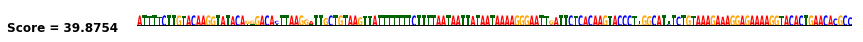

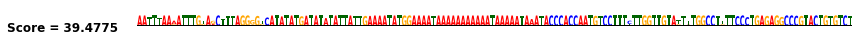

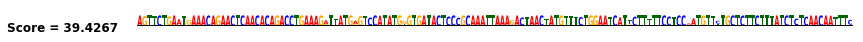

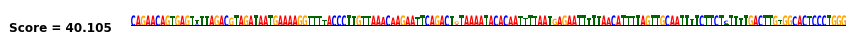

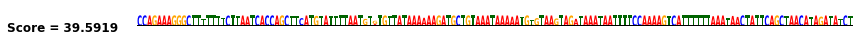

- Real Sequences (Randomly Sampled from Test Set) -


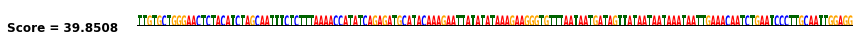

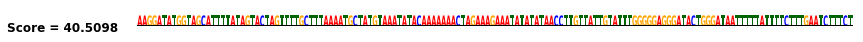

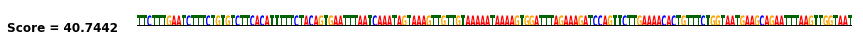

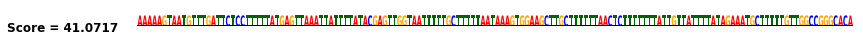

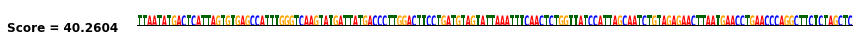

In [115]:
#Visualize a few fake and real sequence patterns

real_scores = []
real_sequences = []
fake_scores = []
fake_pwms = []
fake_sequences = []

for test_index in range(len(data_gens['test'])) :
    real_sequence_batch = data_gens['test'][test_index][0][0][:, 0, :, :, :]
    real_score_batch = discriminator_model.predict_on_batch([real_sequence_batch])

    class_batch = np.zeros((batch_size, 1), dtype=np.int)
    seed_batch = np.random.uniform(low=-1.0, high=1.0, size=(batch_size, 100))

    _, fake_pwm_batch, fake_sequence_batch = generator_model.predict_on_batch([class_batch, seed_batch])
    fake_score_batch = discriminator_model.predict_on_batch([fake_sequence_batch])

    real_scores.append(real_score_batch)
    real_sequences.append(real_sequence_batch)
    fake_scores.append(fake_score_batch)
    fake_pwms.append(fake_pwm_batch)
    fake_sequences.append(fake_sequence_batch)

real_scores = np.concatenate(real_scores, axis=0)
real_sequences = np.concatenate(real_sequences, axis=0)
fake_scores = np.concatenate(fake_scores, axis=0)
fake_pwms = np.concatenate(fake_pwms, axis=0)
fake_sequences = np.concatenate(fake_sequences, axis=0)


print("- Fake Sequences (Randomly Generated) -")

for plot_i in range(5) :
    plot_gan_logo(fake_pwms[plot_i, 0, :, :], fake_scores[plot_i, 0], sequence_template=sequence_templates[0], figsize=(12, 0.55), width_ratios=[1, 7], logo_height=1.0, plot_start=125 - 70, plot_end=125 + 6 + 70)
    #plot_gan_logo(fake_sequences[plot_i, 0, :, :, 0], fake_scores[plot_i, 0, 0], sequence_template=sequence_templates[0], figsize=(12, 0.55), width_ratios=[1, 7], logo_height=1.0, plot_start=20, plot_end=177)

print("- Real Sequences (Randomly Sampled from Test Set) -")

for plot_i in range(5) :
    plot_gan_logo(real_sequences[plot_i, 0, :, :], real_scores[plot_i, 0], sequence_template=sequence_templates[0], figsize=(12, 0.55), width_ratios=[1, 7], logo_height=1.0, plot_start=125 - 70, plot_end=125 + 6 + 70)
